In [3]:
Instance = '../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn'

In [4]:
import numpy as np # linear algebra
import pandas as pd 
import pickle
import os
import glob
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
pd.options.display.float_format = '{:.10f}'.format
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 14,6
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from luminol import anomaly_detector
from luminol.anomaly_detector import AnomalyDetector
from luminol.correlator import Correlator
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
from cydets.algorithm import detect_cycles
import scipy.fft
from datetime import datetime
import pandas as pd
import io
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import math
import jenkspy
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import hw_functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
holsu =0

model_list = ['MNIST_CNN*','AlexNet*','CIFAR10*','InceptionV3*','VGG19*','ResNet50*','InceptionResNetV2*','LeNet5*','ResNetSmall*']
columns_name = ['save_name', 'gpu_utilization_peak' , 'cpu_utilization_peak','gpu_cpu_utilization_peak',
                'gpu_utilization_average', 'cpu_utilization_average', 'gpu_cpu_utilization_average',
                'total_latency','one_epoch_latency',
                'gpu_utilization_memory_peak', 'gpu_utilization_memory_average',
                'luminol_variance','luminol_standared_deviation','luminol_mean','luminol_median',
                'sum_variance','sum_standared_deviation','sum_median']       
all_true_df = []   # 1 epoch latency 평균 ( 모델별로 )
all_pred_df_gpucpu =[] # wave 에서 luminol 로 구한 1 epoch latency 평균
T_all_true_df = []  
T_all_pred_df_gpucpu =[]


df = pd.DataFrame(columns = columns_name)  # 파일하나당 한줄씩 저장해줄것임
df

Empty DataFrame
Columns: [save_name, gpu_utilization_peak, cpu_utilization_peak, gpu_cpu_utilization_peak, gpu_utilization_average, cpu_utilization_average, gpu_cpu_utilization_average, total_latency, one_epoch_latency, gpu_utilization_memory_peak, gpu_utilization_memory_average, luminol_variance, luminol_standared_deviation, luminol_mean, luminol_median, sum_variance, sum_standared_deviation, sum_median]
Index: []

#### 1. dstat-log.csv 전처리 (cpu wave전처리)

In [5]:
fn = r'./'+Instance+'/dstat-log.csv'  # 위치조심

dstat_log = hw_functions.dstatlog_preprocess(fn)
dstat_log.head(3)

totalcpuusage_usr  totalcpuusage_sys  totalcpuusage_idl  totalcpuusage_wai  \
0      16.2910000000       3.3290000000      68.6930000000      11.6660000000   
1      18.5930000000       4.2710000000      74.8740000000       2.2610000000   
2      11.5580000000       2.0100000000      84.9250000000       1.5080000000   

   totalcpuusage_stl      dsktotal_read       dsktotal_writ  nettotal_recv  \
0       0.0220000000 4157766.0089999996 14089770.2730000000              0   
1       0.0000000000 2433024.0000000000        0.0000000000            564   
2       0.0000000000 2760704.0000000000        0.0000000000              0   

   nettotal_send  procs_run  procs_blk     procs_new  memoryusage_used  \
0              0          1          0 67.8870000000         306278400   
1            316          1          0  5.0000000000         404328448   
2              0          1          0  0.0000000000         453988352   

   memoryusage_free  memoryusage_buff  memoryusage_cach   iototal_read  \
0       13327556608         102174720        2594680832 212.3720000000   
1       13228437504         102203392        2595635200  82.0000000000   
2       13176791040         102268928        2597040128 268.0000000000   

   iototal_writ system_day system_time                date  hour  minute  \
0 95.1140000000      11-02    03:56:20 1900-01-01 03:56:20     3      56   
1  0.0000000000      11-02    03:56:21 1900-01-01 03:56:21     3      56   
2  0.0000000000      11-02    03:56:22 1900-01-01 03:56:22     3      56   

   second      hms  
0      20  3_56_20  
1      21  3_56_21  
2      22  3_56_22

#### 2. Data.csv 전처리 (gpu wave 전처리)

In [6]:
Data_T = pd.read_csv(Instance+'/Data.csv')

Data_T ,Data_new_timestamp = hw_functions.Datacsv_preprocess(Data_T)
Data_T.head(3)

timestamp  temperature.gpu  utilization.memory[%]  \
0  2022/02/1103:56:20.895               31           0.0000000000   
1  2022/02/1103:56:21.011               31           0.0000000000   
2  2022/02/1103:56:21.125               31           0.0000000000   

   utilization.gpu[%]  power.draw[W]  clocks.current.sm[MHz]  \
0        0.0000000000   9.4100000000          300.0000000000   
1        0.0000000000   9.4100000000          300.0000000000   
2        0.0000000000   9.4100000000          300.0000000000   

                     date  hour  minute  second  millisecond      hms  \
0 2022-02-11 03:56:20.895     3      56      20       895000  3_56_20   
1 2022-02-11 03:56:21.011     3      56      21        11000  3_56_21   
2 2022-02-11 03:56:21.125     3      56      21       125000  3_56_21   

          new_timestamp_gpu  
0 20220211035620.8945312500  
1 20220211035621.0117187500  
2 20220211035621.1250000000

#### 3. dstat-log.csv + Data.csv = Data_GPUCPU

In [7]:
Data_GPUCPU = pd.merge(Data_T , dstat_log , on = "hms")
Data_GPUCPU.head(3)

timestamp  temperature.gpu  utilization.memory[%]  \
0  2022/02/1103:56:20.895               31           0.0000000000   
1  2022/02/1103:56:21.011               31           0.0000000000   
2  2022/02/1103:56:21.125               31           0.0000000000   

   utilization.gpu[%]  power.draw[W]  clocks.current.sm[MHz]  \
0        0.0000000000   9.4100000000          300.0000000000   
1        0.0000000000   9.4100000000          300.0000000000   
2        0.0000000000   9.4100000000          300.0000000000   

                   date_x  hour_x  minute_x  second_x  millisecond      hms  \
0 2022-02-11 03:56:20.895       3        56        20       895000  3_56_20   
1 2022-02-11 03:56:21.011       3        56        21        11000  3_56_21   
2 2022-02-11 03:56:21.125       3        56        21       125000  3_56_21   

          new_timestamp_gpu  totalcpuusage_usr  totalcpuusage_sys  \
0 20220211035620.8945312500      16.2910000000       3.3290000000   
1 20220211035621.0117187500      18.5930000000       4.2710000000   
2 20220211035621.1250000000      18.5930000000       4.2710000000   

   totalcpuusage_idl  totalcpuusage_wai  totalcpuusage_stl      dsktotal_read  \
0      68.6930000000      11.6660000000       0.0220000000 4157766.0089999996   
1      74.8740000000       2.2610000000       0.0000000000 2433024.0000000000   
2      74.8740000000       2.2610000000       0.0000000000 2433024.0000000000   

        dsktotal_writ  nettotal_recv  nettotal_send  procs_run  procs_blk  \
0 14089770.2730000000              0              0          1          0   
1        0.0000000000            564            316          1          0   
2        0.0000000000            564            316          1          0   

      procs_new  memoryusage_used  memoryusage_free  memoryusage_buff  \
0 67.8870000000         306278400       13327556608         102174720   
1  5.0000000000         404328448       13228437504         102203392   
2  5.0000000000         404328448       13228437504         102203392   

   memoryusage_cach   iototal_read  iototal_writ system_day system_time  \
0        2594680832 212.3720000000 95.1140000000      11-02    03:56:20   
1        2595635200  82.0000000000  0.0000000000      11-02    03:56:21   
2        2595635200  82.0000000000  0.0000000000      11-02    03:56:21   

               date_y  hour_y  minute_y  second_y  
0 1900-01-01 03:56:20       3        56        20  
1 1900-01-01 03:56:21       3        56        21  
2 1900-01-01 03:56:21       3        56        21

#### 4. Model 별로 끊어서보기

-----------------------------------------------------------------
MNIST_CNN*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
373
[ 1 EPOCH latency 평균 ? ]  :  0:00:04.396100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  3.98275
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.6234380108486373
luminol 분산  :  0.07613974166131625
luminol 표준편차  :  0.27593430678572073
luminol 평균값 : 0.443244411134272
luminol 중앙값 : 0.3994629308098709


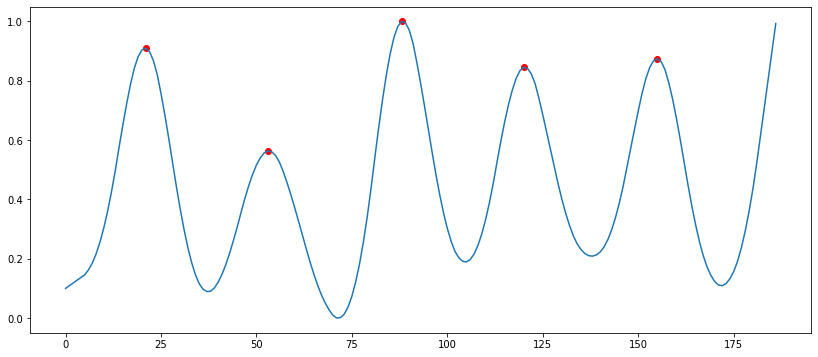

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
494
[ 1 EPOCH latency 평균 ? ]  :  0:00:05.821900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.42175
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.6742307069329256
luminol 분산  :  0.034991991023269796
luminol 표준편차  :  0.18706146322337425
luminol 평균값 : 0.5874561460249488
luminol 중앙값 : 0.5748397191881092


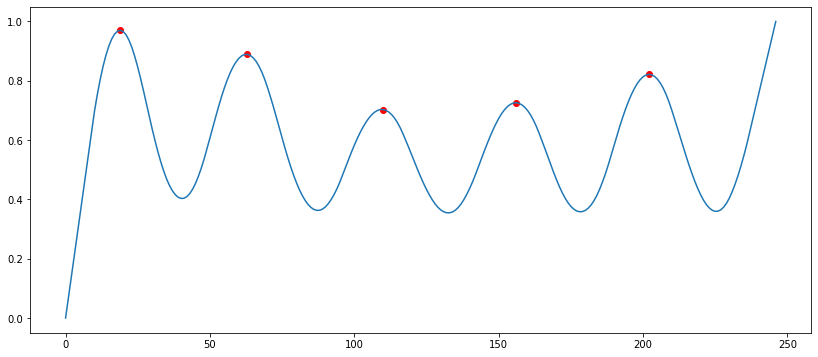

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
215
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
210
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
96
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize16_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
131
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
325
[ 1 EPOCH latency 평균 ? ]  :  0:00:03.873200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  3.1795999999999998
클러스터 레이블 : 
[0 1 2 3 4 5]
클러스터 갯수 : 5
sum 데이터 분산  :  2.8080925392021885
luminol 분산  :  0.0895539844462065
luminol 표준편차  :  0.2992557174829021
luminol 평균값 : 0.45186469037906846
luminol 중앙값 : 0.44892450995681094


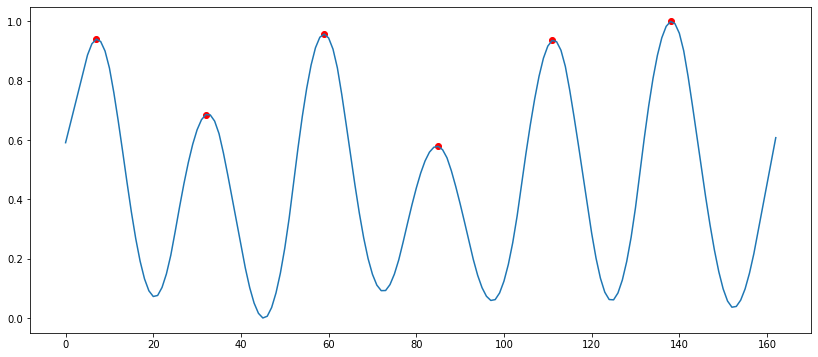

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
326
[ 1 EPOCH latency 평균 ? ]  :  0:00:03.845700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  3.432
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.7197766805116768
luminol 분산  :  0.03089475123090903
luminol 표준편차  :  0.17576902807636227
luminol 평균값 : 0.33088558988542993
luminol 중앙값 : 0.3201140987120988


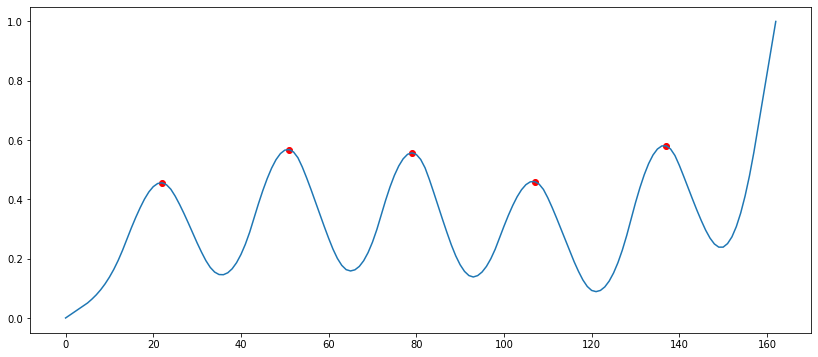

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
235
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
275
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize256_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
361
[ 1 EPOCH latency 평균 ? ]  :  0:00:04.236900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  3.1526
클러스터 레이블 : 
[0 1 2 3 4 5]
클러스터 갯수 : 5
sum 데이터 분산  :  2.3474943064130644
luminol 분산  :  0.02867535370457593
luminol 표준편차  :  0.16933798659655763
luminol 평균값 : 0.2845379022457178
luminol 중앙값 : 0.26064691357329073


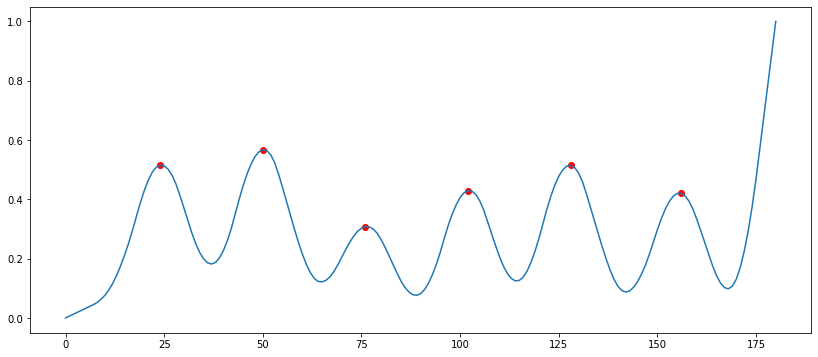

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
787
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.928600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  8.74025
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  3.872936110450159
luminol 분산  :  0.03828423384311222
luminol 표준편차  :  0.19566357311240185
luminol 평균값 : 0.2478852775867482
luminol 중앙값 : 0.20259949641496888


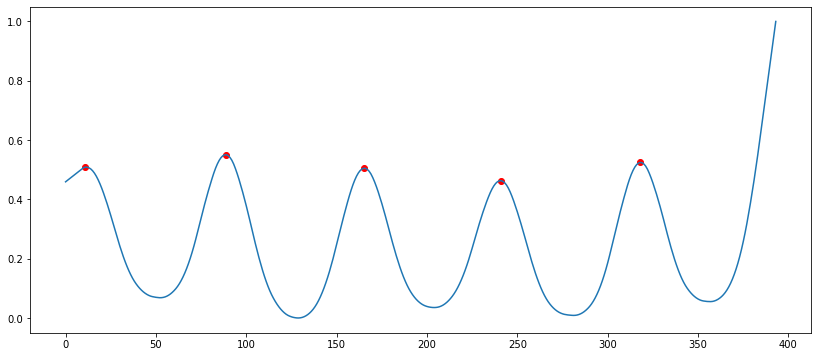

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
265
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
74
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
72
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
150
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize64_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
417
[ 1 EPOCH latency 평균 ? ]  :  0:00:04.970900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  4.51175
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.9699512534264174
luminol 분산  :  0.019912582736326623
luminol 표준편차  :  0.14111195107547278
luminol 평균값 : 0.30038922568818693
luminol 중앙값 : 0.2809337262394925


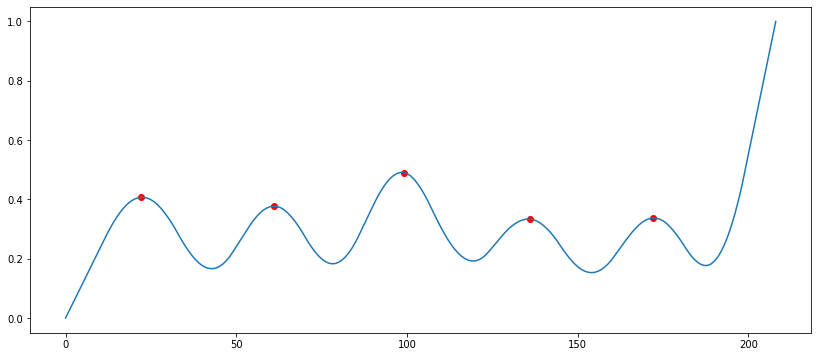

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
205
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
487
[ 1 EPOCH latency 평균 ? ]  :  0:00:05.761600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.2765
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.6105147021621558
luminol 분산  :  0.018692856987506702
luminol 표준편차  :  0.136721823376909
luminol 평균값 : 0.5773427646657893
luminol 중앙값 : 0.5681615523976595


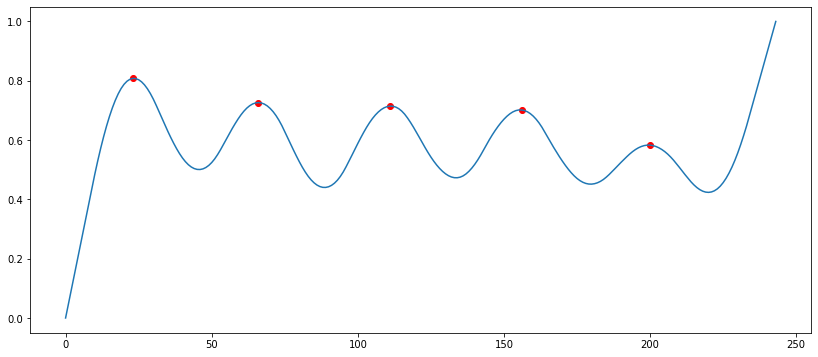

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
636
[ 1 EPOCH latency 평균 ? ]  :  0:00:07.485400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.10425
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.4846271238991564
luminol 분산  :  0.0270273850625064
luminol 표준편차  :  0.1644000762241502
luminol 평균값 : 0.42974579623027853
luminol 중앙값 : 0.4077173766286706


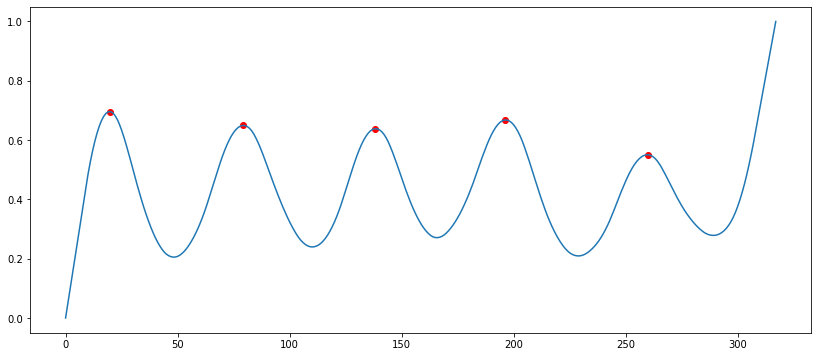

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
82
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize128_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
187
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/MNIST_CNN_batchsize32_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
470
[ 1 EPOCH latency 평균 ? ]  :  0:00:05.324500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.04625
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  3.0598958254324535
luminol 분산  :  0.03988225006741865
luminol 표준편차  :  0.19970540820773644
luminol 평균값 : 0.28877492942016036
luminol 중앙값 : 0.2878163364755929


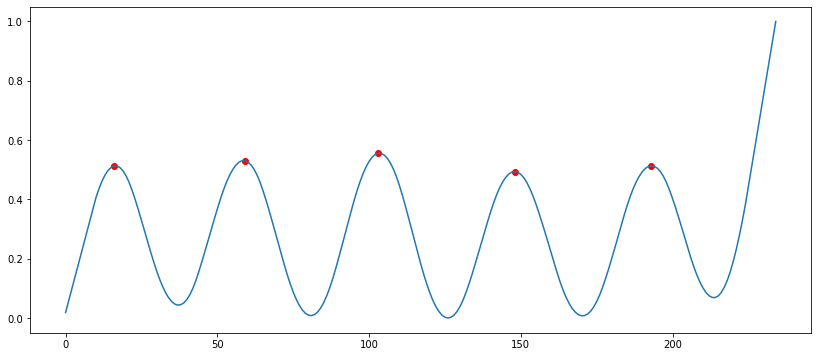

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
MNIST_CNN*
mae
0.47970999999999986
rsme
0.5350914150871793
mape
10.061636739359006
r2
0.8824836003413498
-----------------------------------------------------------------
AlexNet*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
4008
[ 1 EPOCH latency 평균 ? ]  :  0:00:47.115600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  44.27375
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.3561110276988841
luminol 분산  :  0.022926211289419067
luminol 표준편차  :  0.15141403927449748
luminol 평균값 : 0.31887368319352655
luminol 중앙값 : 0.2786576293446584


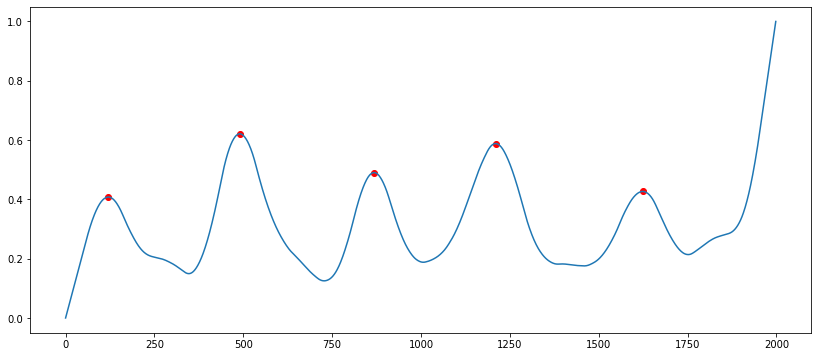

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
6187
[ 1 EPOCH latency 평균 ? ]  :  0:01:13.031500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  70.183
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  0.5087709470910861
luminol 분산  :  0.01683068420776411
luminol 표준편차  :  0.1297331268711431
luminol 평균값 : 0.1474186483210618
luminol 중앙값 : 0.1133134745985346


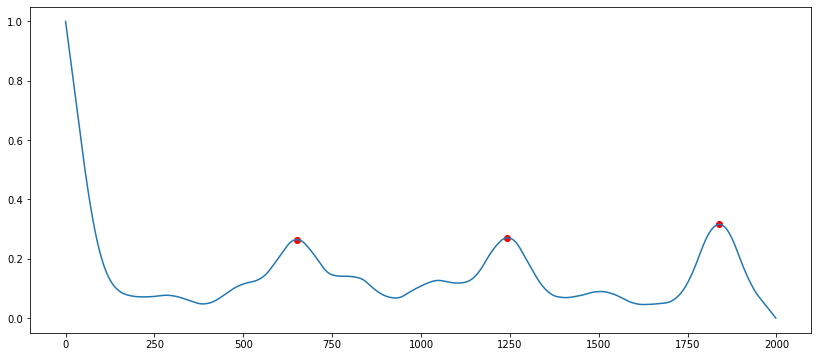

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
6551
[ 1 EPOCH latency 평균 ? ]  :  0:01:15.983000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  38.26433333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.2450134275884248
luminol 분산  :  0.026100618905636808
luminol 표준편차  :  0.16155685966753874
luminol 평균값 : 0.23604723486681733
luminol 중앙값 : 0.1955533230143199


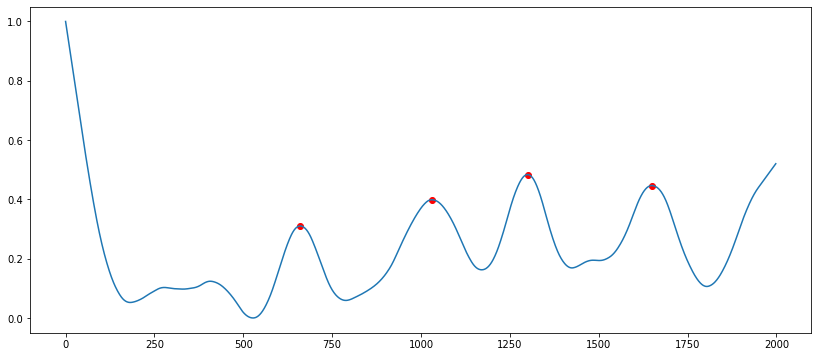

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1558
[ 1 EPOCH latency 평균 ? ]  :  0:00:18.148000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  17.33775
클러스터 레이블 : 
[0 1 2 3 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7506272178179438
luminol 분산  :  0.011686169726874288
luminol 표준편차  :  0.10810258889996247
luminol 평균값 : 0.26751922662920935
luminol 중앙값 : 0.2404476721064498


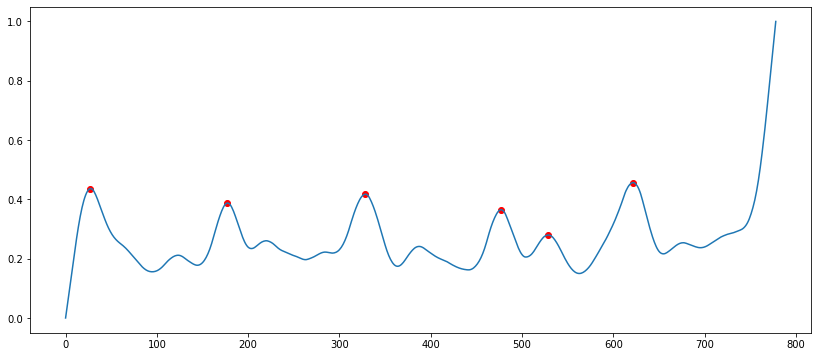

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
4721
[ 1 EPOCH latency 평균 ? ]  :  0:00:55.792100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  54.15633333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.6221381434013966
luminol 분산  :  0.014457676556359862
luminol 표준편차  :  0.12024007882715257
luminol 평균값 : 0.18585253369075883
luminol 중앙값 : 0.1408459410907388


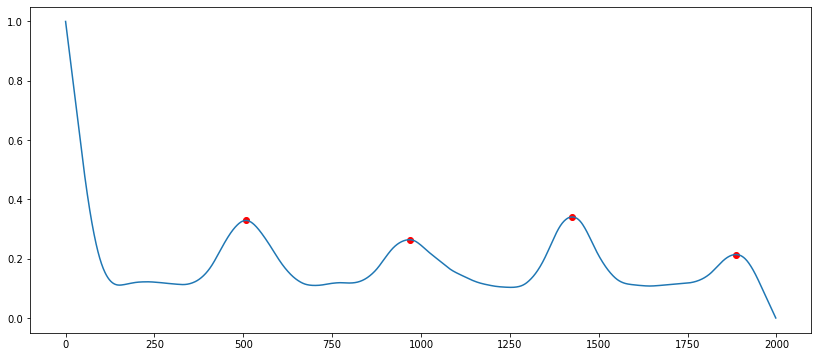

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
5505
[ 1 EPOCH latency 평균 ? ]  :  0:01:04.715000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  63.4035
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  0.46247651131721906
luminol 분산  :  0.023405760617218923
luminol 표준편차  :  0.15298941341550049
luminol 평균값 : 0.2579247982211186
luminol 중앙값 : 0.19885343198688576


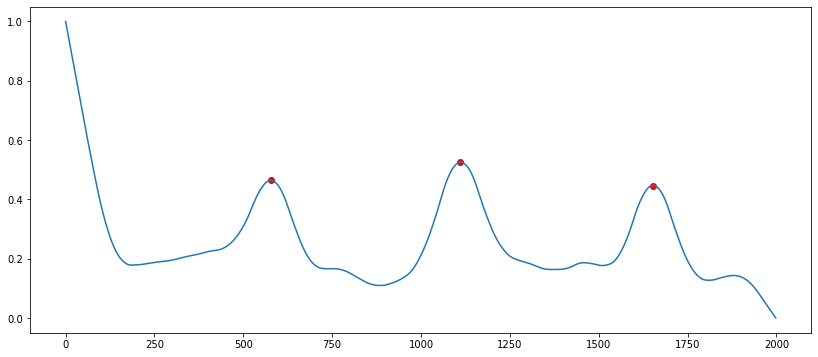

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize128_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
5680
[ 1 EPOCH latency 평균 ? ]  :  0:01:06.564900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  41.69475
클러스터 레이블 : 
[0 1 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.9908068254065202
luminol 분산  :  0.03481043817790867
luminol 표준편차  :  0.18657555621760497
luminol 평균값 : 0.3323190720209377
luminol 중앙값 : 0.309846376688169


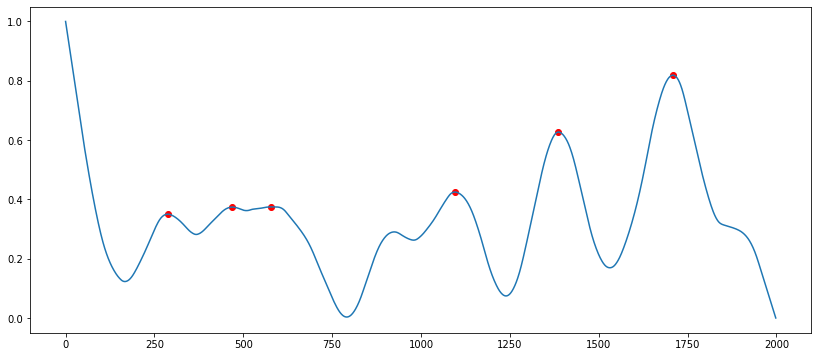

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
3909
[ 1 EPOCH latency 평균 ? ]  :  0:00:45.849000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  44.36775
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.4903230487671258
luminol 분산  :  0.03560883141968516
luminol 표준편차  :  0.18870302440524148
luminol 평균값 : 0.2850570009945878
luminol 중앙값 : 0.2297325092781711


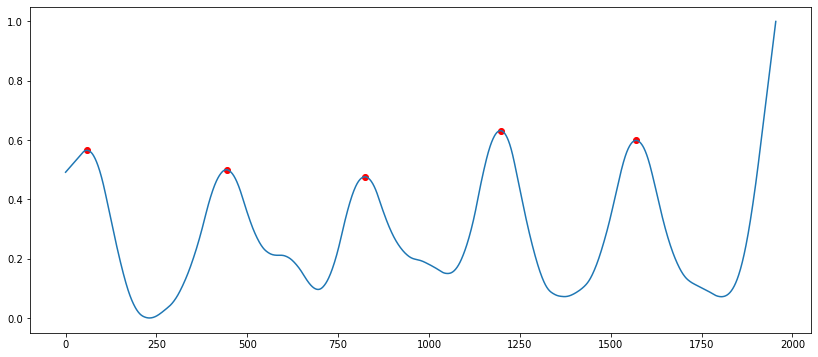

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
6842
[ 1 EPOCH latency 평균 ? ]  :  0:01:19.351600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  71.7135
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  0.35027996326103233
luminol 분산  :  0.05423110821926218
luminol 표준편차  :  0.23287573557428043
luminol 평균값 : 0.3522468521269976
luminol 중앙값 : 0.2401705720499572


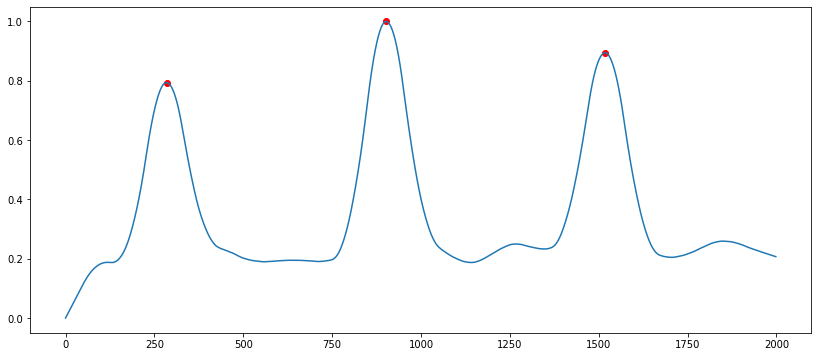

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
11796
[ 1 EPOCH latency 평균 ? ]  :  0:02:18.069000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  46.13133333333334
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.7739202390566964
luminol 분산  :  0.03308119848925279
luminol 표준편차  :  0.18188237542228436
luminol 평균값 : 0.2434039845536239
luminol 중앙값 : 0.19101127962915956


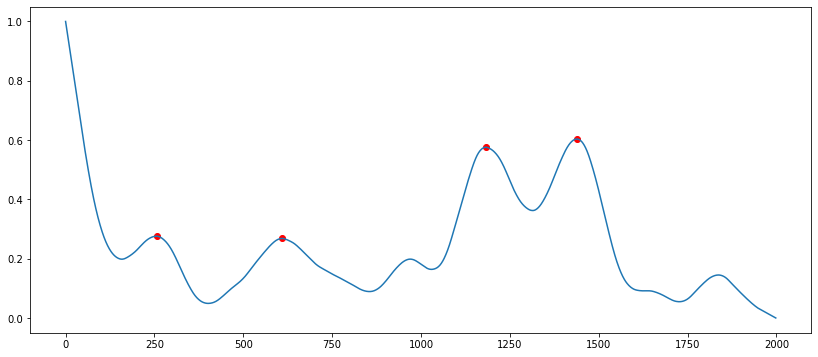

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1522
[ 1 EPOCH latency 평균 ? ]  :  0:00:17.862700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  14.687
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.8534539127761566
luminol 분산  :  0.018566163501442103
luminol 표준편차  :  0.1362577098788986
luminol 평균값 : 0.10539484114035436
luminol 중앙값 : 0.05606291257010199


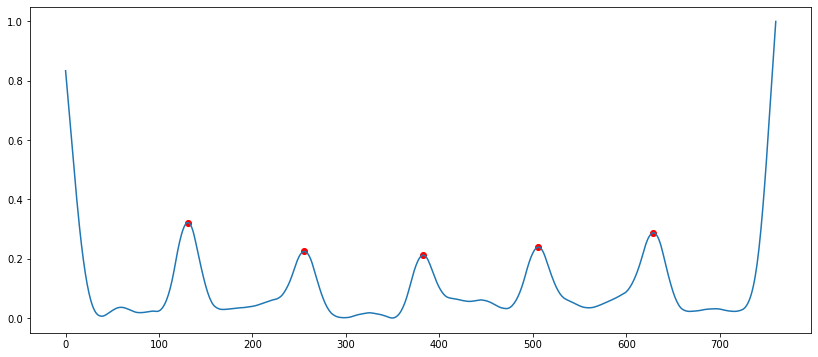

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize32_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
8320
[ 1 EPOCH latency 평균 ? ]  :  0:01:36.595100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  46.547333333333334
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.730066540386374
luminol 분산  :  0.0594780407505948
luminol 표준편차  :  0.24388120212635248
luminol 평균값 : 0.44926981231870633
luminol 중앙값 : 0.4244519619669398


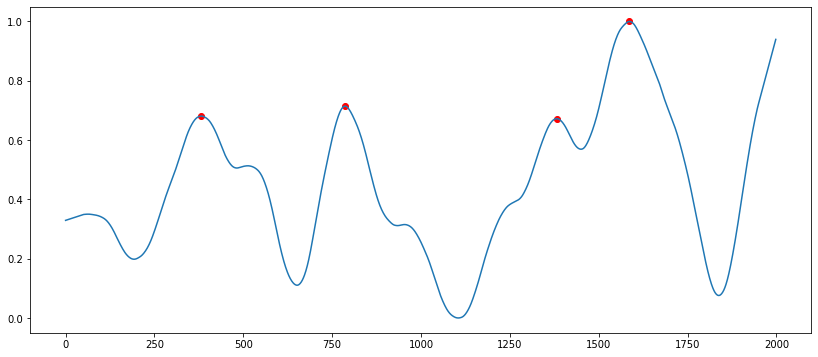

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
4774
[ 1 EPOCH latency 평균 ? ]  :  0:00:56.563300
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  55.425666666666665
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.35139709309250994
luminol 분산  :  0.02576760991084297
luminol 표준편차  :  0.1605229264337122
luminol 평균값 : 0.14574581459353955
luminol 중앙값 : 0.07649762086751813


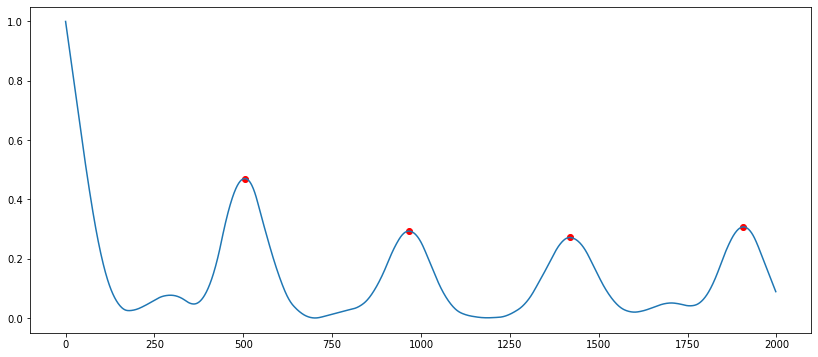

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1365
[ 1 EPOCH latency 평균 ? ]  :  0:00:15.849500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  14.41125
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.0737599525813033
luminol 분산  :  0.04544132466972727
luminol 표준편차  :  0.21316970861200535
luminol 평균값 : 0.21588193608269685
luminol 중앙값 : 0.13259340716530954


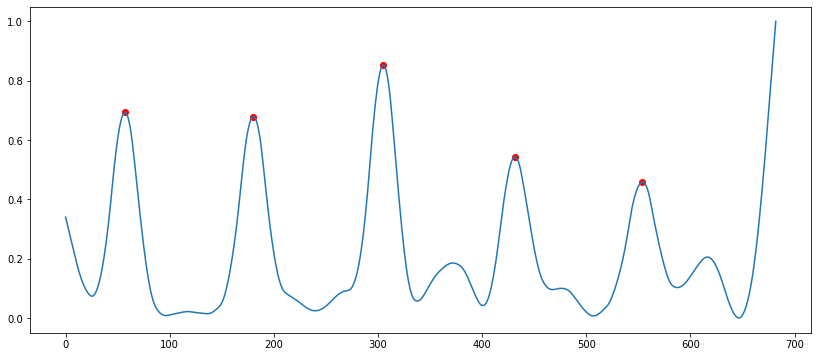

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize16_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2029
[ 1 EPOCH latency 평균 ? ]  :  0:00:23.385200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  22.861333333333334
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.1500722286753573
luminol 분산  :  0.0393364113678237
luminol 표준편차  :  0.19833409028158447
luminol 평균값 : 0.33739813943708385
luminol 중앙값 : 0.3315637784870726


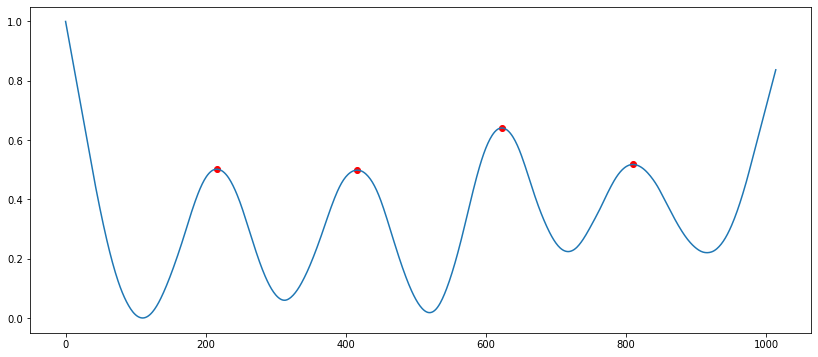

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1357
[ 1 EPOCH latency 평균 ? ]  :  0:00:16.189500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  15.2915
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7503936761019702
luminol 분산  :  0.05146807247977018
luminol 표준편차  :  0.2268657587203723
luminol 평균값 : 0.20133230929236084
luminol 중앙값 : 0.07335347291490783


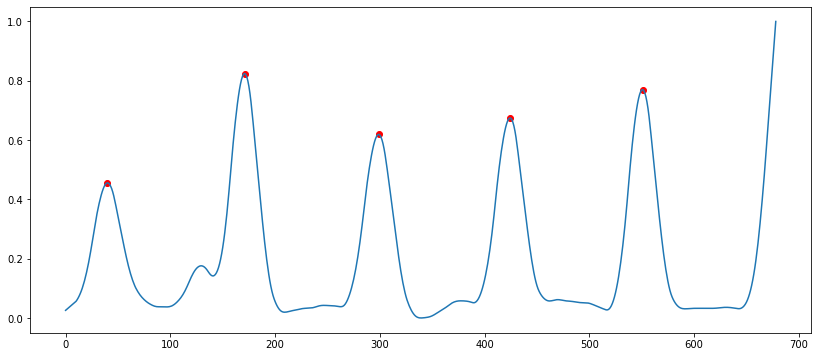

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
4413
[ 1 EPOCH latency 평균 ? ]  :  0:00:52.240900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  49.48075
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.2598273495011659
luminol 분산  :  0.0364103569901158
luminol 표준편차  :  0.1908149810421493
luminol 평균값 : 0.5042663793957866
luminol 중앙값 : 0.43667122300163613


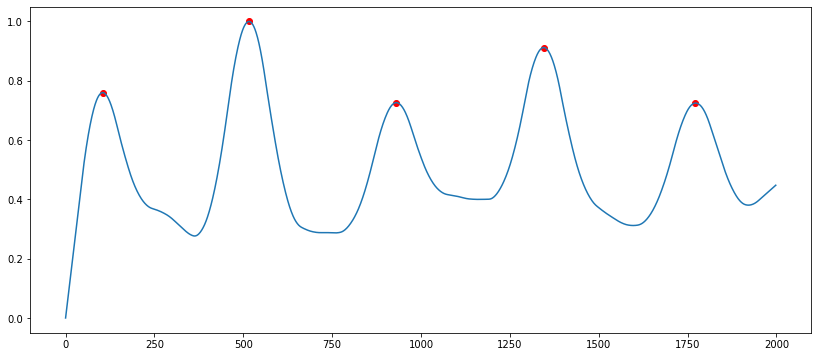

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/AlexNet_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
4021
[ 1 EPOCH latency 평균 ? ]  :  0:00:47.216300
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  45.452333333333335
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.5573258270853095
luminol 분산  :  0.02929577392958716
luminol 표준편차  :  0.17116008275759614
luminol 평균값 : 0.24766793733166143
luminol 중앙값 : 0.20867977256362427


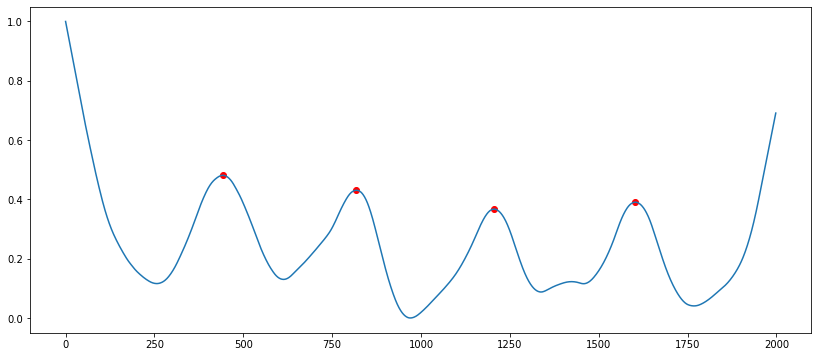

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
AlexNet*
mae
13.046612962962966
rsme
26.983092826983324
mape
15.738072110767323
r2
0.2384945157364321
-----------------------------------------------------------------
CIFAR10*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
523
[ 1 EPOCH latency 평균 ? ]  :  0:00:06.135200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.687
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.7918688702344914
luminol 분산  :  0.03385549820591301
luminol 표준편차  :  0.1839986364240589
luminol 평균값 : 0.48736877873971485
luminol 중앙값 : 0.46757797485074254


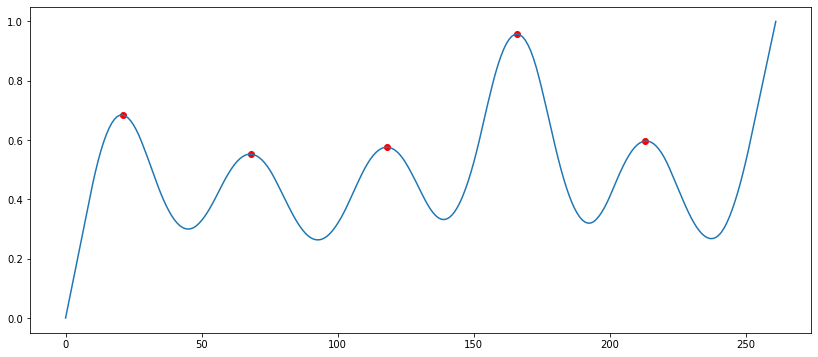

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize32_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
644
[ 1 EPOCH latency 평균 ? ]  :  0:00:07.301300
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  6.888
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  3.3039420867806193
luminol 분산  :  0.05401335458421125
luminol 표준편차  :  0.2324077334862402
luminol 평균값 : 0.3055197543095773
luminol 중앙값 : 0.27609680605295883


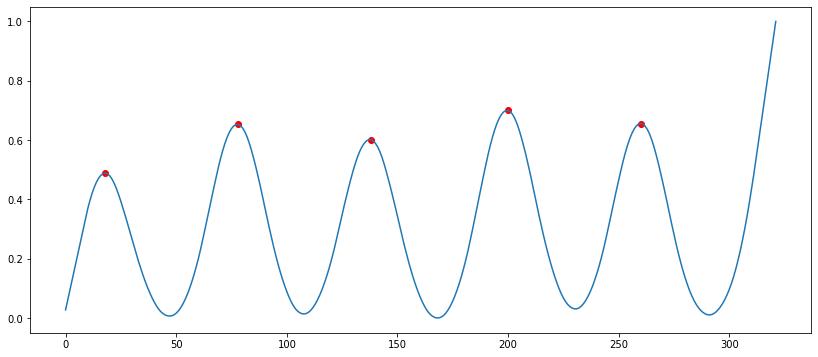

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize128_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
352
[ 1 EPOCH latency 평균 ? ]  :  0:00:04.048100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  3.742
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.3265155741358945
luminol 분산  :  0.07432683464391691
luminol 표준편차  :  0.2726294823453929
luminol 평균값 : 0.3927476190026965
luminol 중앙값 : 0.34906813644648726


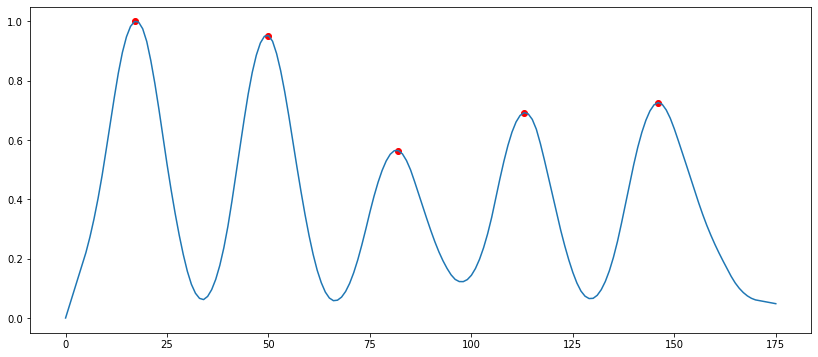

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
604
[ 1 EPOCH latency 평균 ? ]  :  0:00:06.945200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  6.52925
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.252379544140389
luminol 분산  :  0.024652873839981045
luminol 표준편차  :  0.15701233658531755
luminol 평균값 : 0.3517470955774041
luminol 중앙값 : 0.3329684388560017


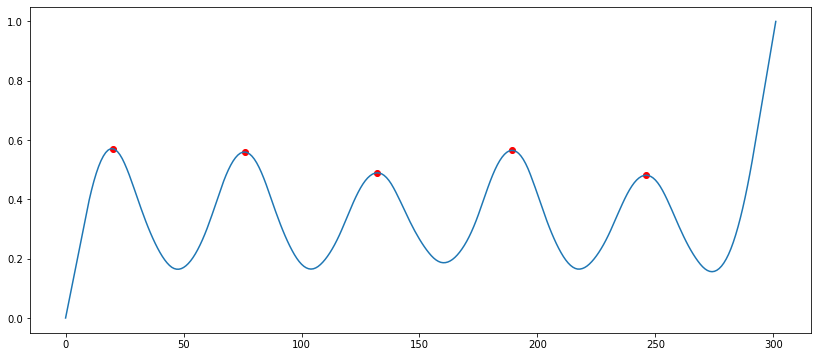

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
142
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
678
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.054800
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.14475
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.3636707656149627
luminol 분산  :  0.029417630709453024
luminol 표준편차  :  0.17151568648217871
luminol 평균값 : 0.20481760152366874
luminol 중앙값 : 0.17141675038917217


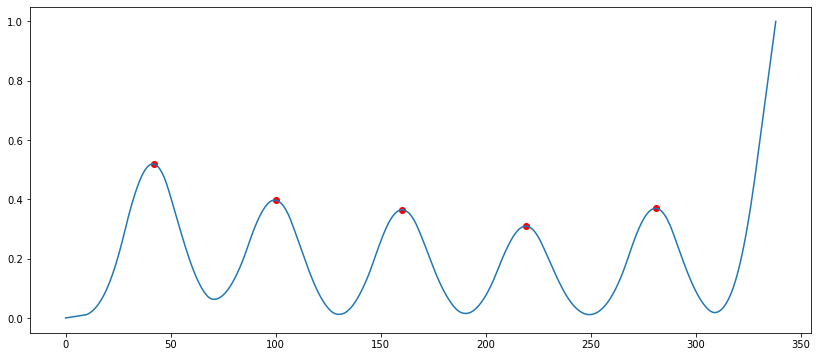

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize16_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
221
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
688
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.110600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.5
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.497783555531243
luminol 분산  :  0.02384119752677408
luminol 표준편차  :  0.15440595042540972
luminol 평균값 : 0.3145458088619045
luminol 중앙값 : 0.29018804881662186


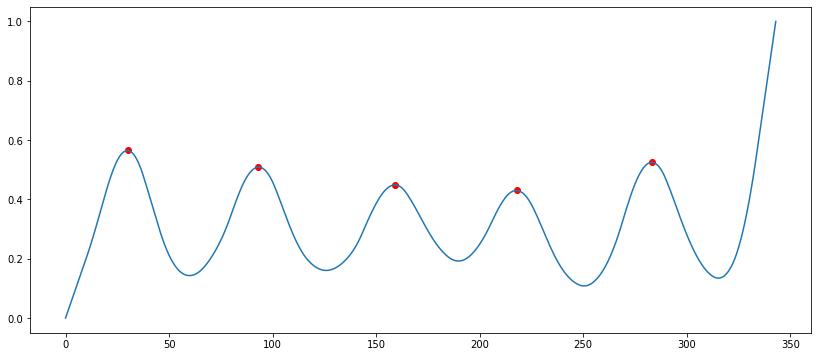

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
153
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
888
[ 1 EPOCH latency 평균 ? ]  :  0:00:10.464900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  9.74225
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.6297290242493154
luminol 분산  :  0.02791584789382862
luminol 표준편차  :  0.16708036357941233
luminol 평균값 : 0.18193054066625894
luminol 중앙값 : 0.1356726748366812


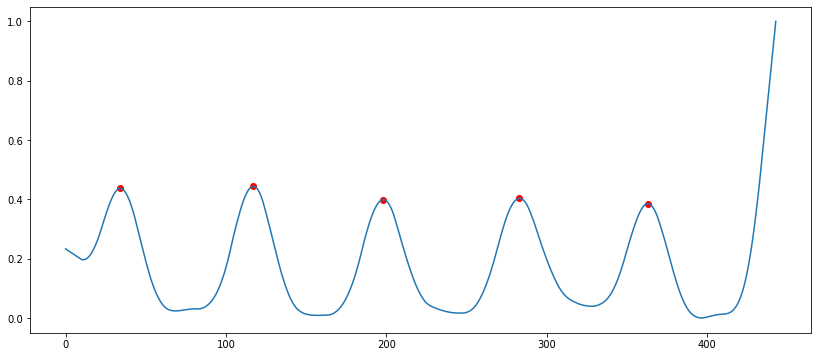

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
482
[ 1 EPOCH latency 평균 ? ]  :  0:00:05.754600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.06725
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.5784257311808638
luminol 분산  :  0.06257932496185334
luminol 표준편차  :  0.25015859961603026
luminol 평균값 : 0.4820191026987025
luminol 중앙값 : 0.49262829647720197


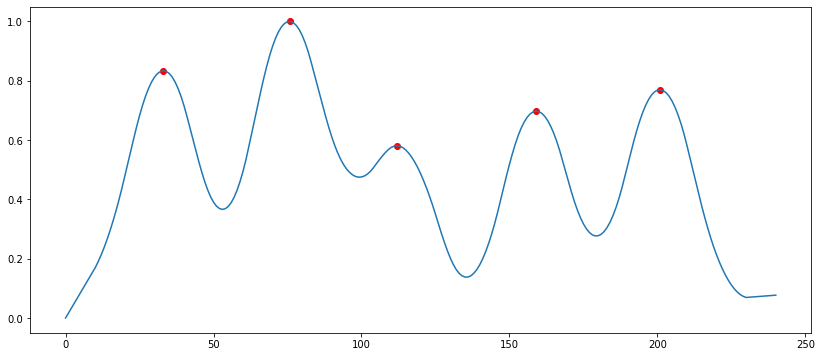

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
152
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
297
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
728
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.579100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.08425
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.5272430353449
luminol 분산  :  0.06809436488870953
luminol 표준편차  :  0.2609489698939422
luminol 평균값 : 0.36238240462546806
luminol 중앙값 : 0.32391765510118004


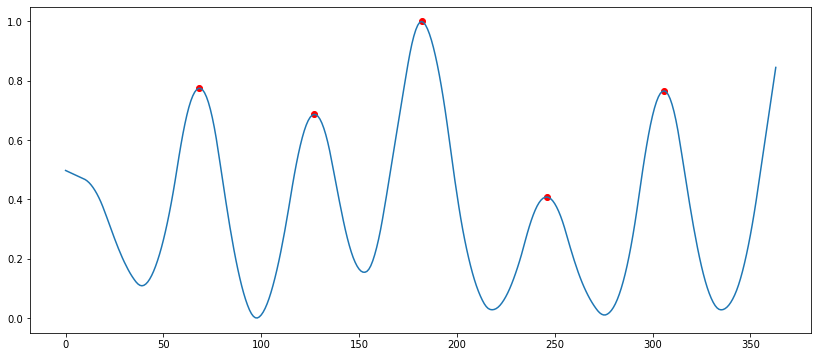

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize64_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
843
[ 1 EPOCH latency 평균 ? ]  :  0:00:09.994000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  8.8865
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.1919760507392052
luminol 분산  :  0.03122142277617322
luminol 표준편차  :  0.17669584821430645
luminol 평균값 : 0.19460887413130507
luminol 중앙값 : 0.131023909945205


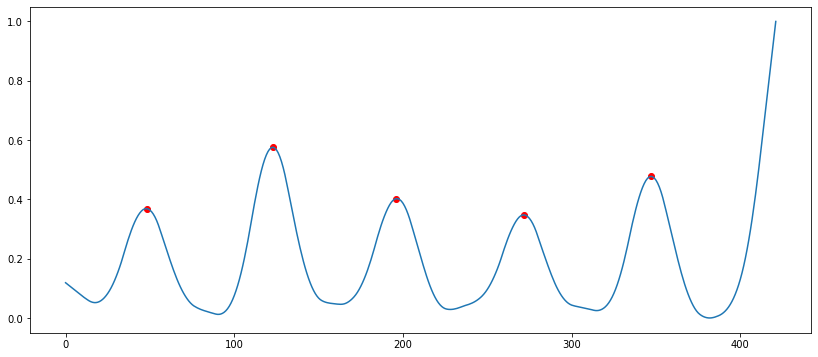

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
544
[ 1 EPOCH latency 평균 ? ]  :  0:00:06.395600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.204
클러스터 레이블 : 
[0 1 2 3 4 5]
클러스터 갯수 : 5
sum 데이터 분산  :  1.4339981520292313
luminol 분산  :  0.054190621172305026
luminol 표준편차  :  0.23278879090777765
luminol 평균값 : 0.31195343644891915
luminol 중앙값 : 0.27993428508313434


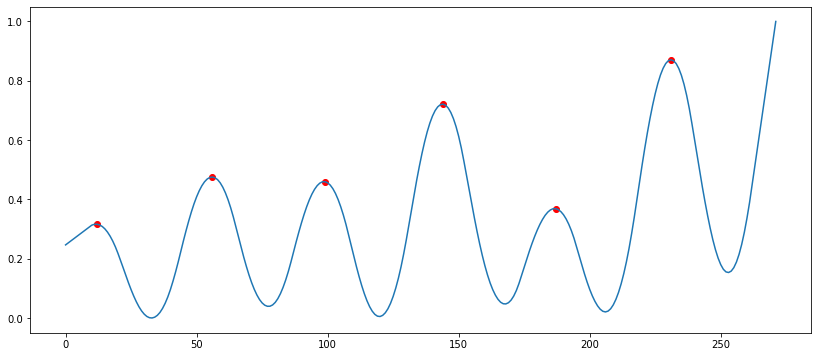

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
721
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.416100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.912
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.2317883985472555
luminol 분산  :  0.02858621831668412
luminol 표준편차  :  0.16907459394209445
luminol 평균값 : 0.3888623930363215
luminol 중앙값 : 0.36649807340182794


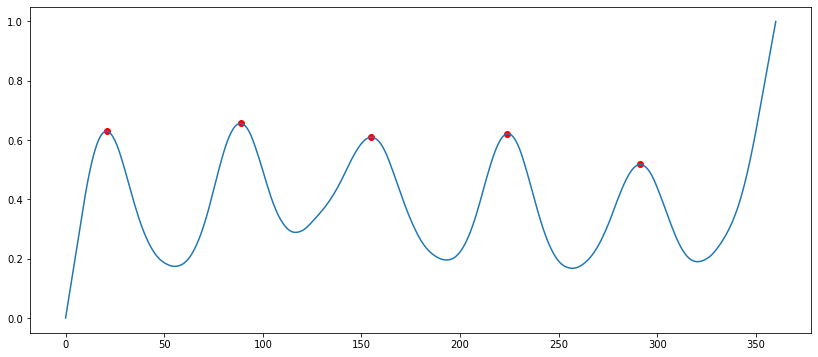

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize256_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
804
[ 1 EPOCH latency 평균 ? ]  :  0:00:09.408900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.093000000000001
클러스터 레이블 : 
[0 1 2 3 4 5]
클러스터 갯수 : 5
sum 데이터 분산  :  1.541392531416433
luminol 분산  :  0.019560121431371952
luminol 표준편차  :  0.13985750402238684
luminol 평균값 : 0.1812401971794704
luminol 중앙값 : 0.15265199165773713


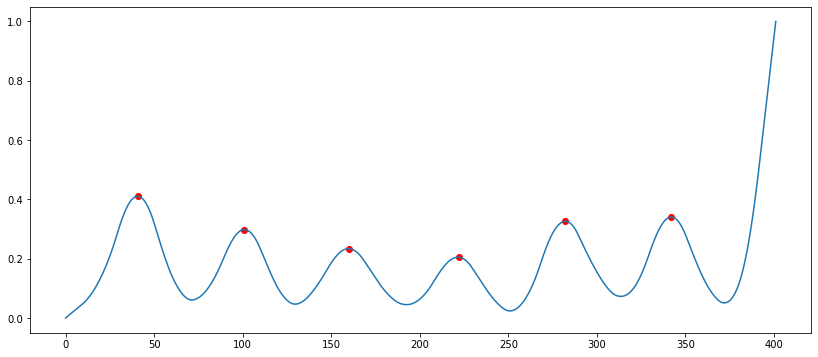

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
429
[ 1 EPOCH latency 평균 ? ]  :  0:00:04.894500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  4.543
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.8558617146363026
luminol 분산  :  0.021132120076333014
luminol 표준편차  :  0.14536891028116367
luminol 평균값 : 0.5211846422490345
luminol 중앙값 : 0.5187273435809167


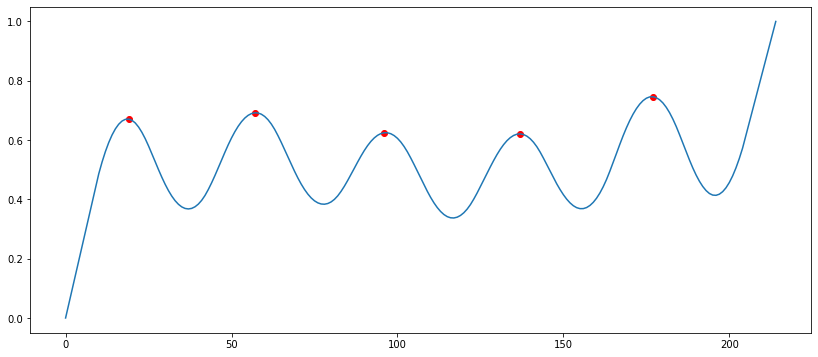

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
173
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
925
[ 1 EPOCH latency 평균 ? ]  :  0:00:10.759100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  10.291
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.7504824215496475
luminol 분산  :  0.018912410366750038
luminol 표준편차  :  0.13752239950913464
luminol 평균값 : 0.39836708035851925
luminol 중앙값 : 0.3453031553775461


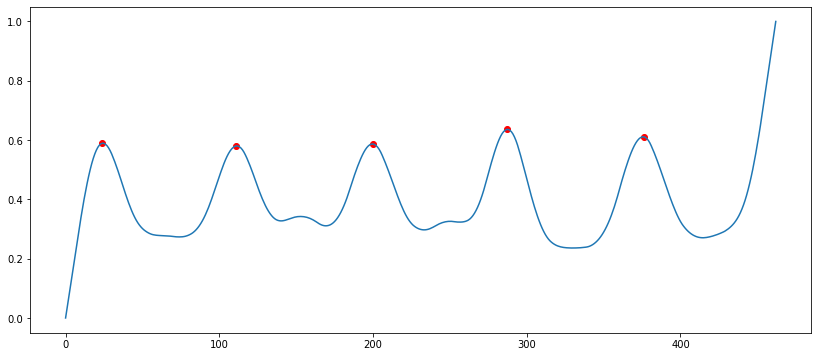

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
1143
[ 1 EPOCH latency 평균 ? ]  :  0:00:12.984400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  12.680666666666667
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.2845509443638572
luminol 분산  :  0.07525433049491381
luminol 표준편차  :  0.2743252275947544
luminol 평균값 : 0.2594532996272019
luminol 중앙값 : 0.09737113672988708


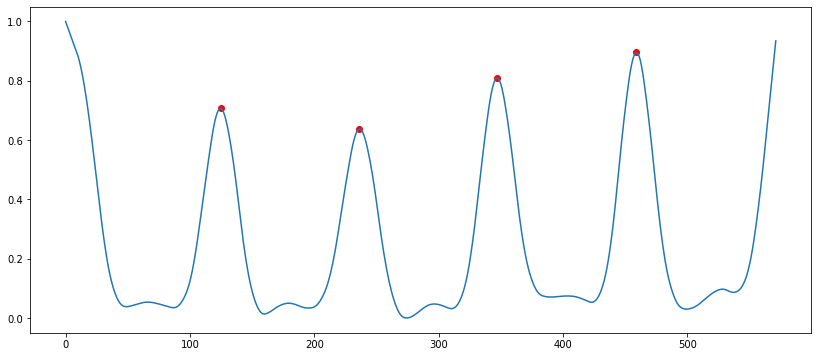

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/CIFAR10_CNN_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
499
[ 1 EPOCH latency 평균 ? ]  :  0:00:05.822700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.364
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.5472694462095415
luminol 분산  :  0.04050168895106675
luminol 표준편차  :  0.20125031416389577
luminol 평균값 : 0.601373036411048
luminol 중앙값 : 0.6050323823233197


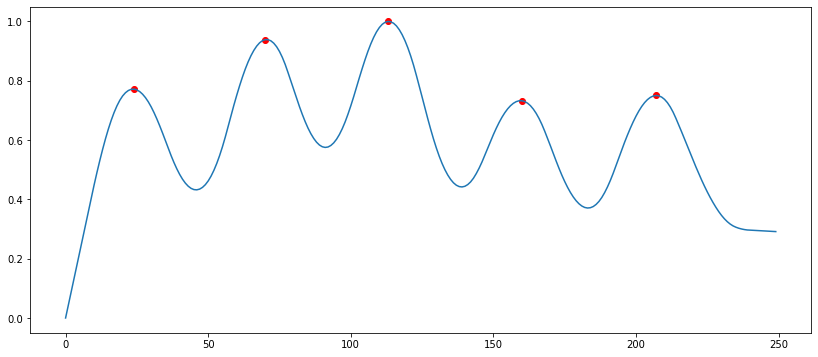

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
CIFAR10*
mae
0.7476578431372547
rsme
0.9067716033294021
mape
9.628443373587452
r2
0.8402415344729206
-----------------------------------------------------------------
InceptionV3*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1178
[ 1 EPOCH latency 평균 ? ]  :  0:00:13.672500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  11.31425
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.8658248306314729
luminol 분산  :  0.033171207178581484
luminol 표준편차  :  0.1821296438765021
luminol 평균값 : 0.18138681625998854
luminol 중앙값 : 0.0953850142940559


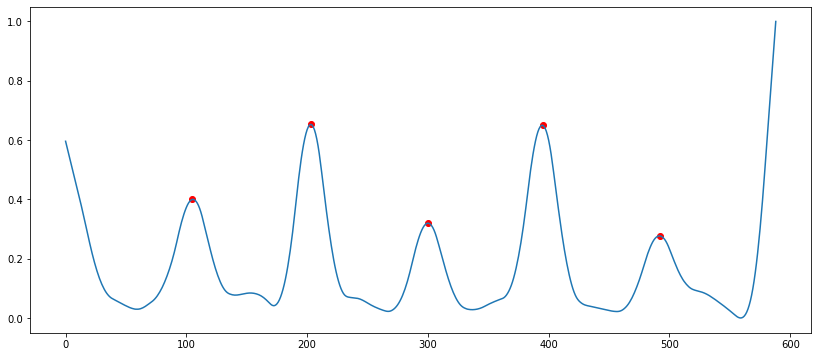

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1569
[ 1 EPOCH latency 평균 ? ]  :  0:00:18.223500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  15.77225
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7636732031434722
luminol 분산  :  0.017376684130653908
luminol 표준편차  :  0.13182065138154153
luminol 평균값 : 0.1829189908966412
luminol 중앙값 : 0.12610778538628334


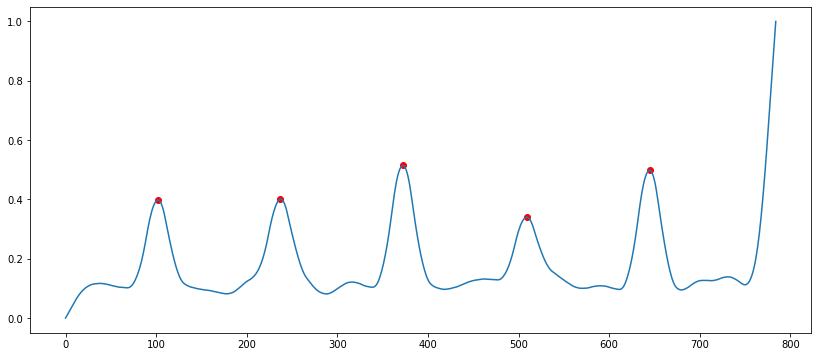

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1509
[ 1 EPOCH latency 평균 ? ]  :  0:00:17.594100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  16.04
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7592309713264348
luminol 분산  :  0.04961075090780136
luminol 표준편차  :  0.22273470970596693
luminol 평균값 : 0.24107943819062613
luminol 중앙값 : 0.12743344751741387


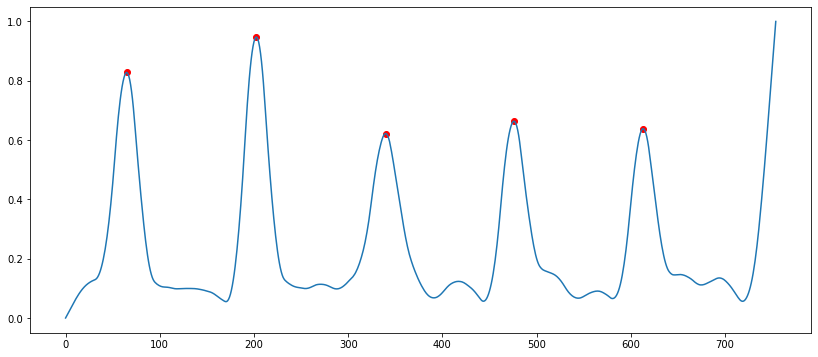

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1828
[ 1 EPOCH latency 평균 ? ]  :  0:00:21.539700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  20.0975
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.7236805654778982
luminol 분산  :  0.06183633968518761
luminol 표준편차  :  0.24866913697760648
luminol 평균값 : 0.4287198998832517
luminol 중앙값 : 0.42367703812327506


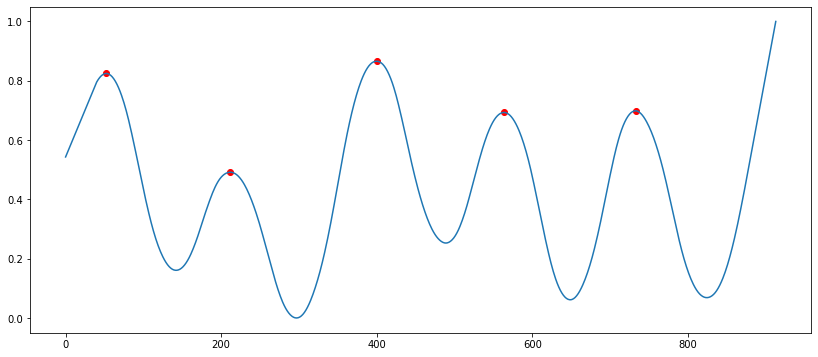

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize64_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1954
[ 1 EPOCH latency 평균 ? ]  :  0:00:22.779400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.534000000000002
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.6540001794927428
luminol 분산  :  0.01780751987223197
luminol 표준편차  :  0.13344481957810117
luminol 평균값 : 0.5117578910336265
luminol 중앙값 : 0.4923138973470887


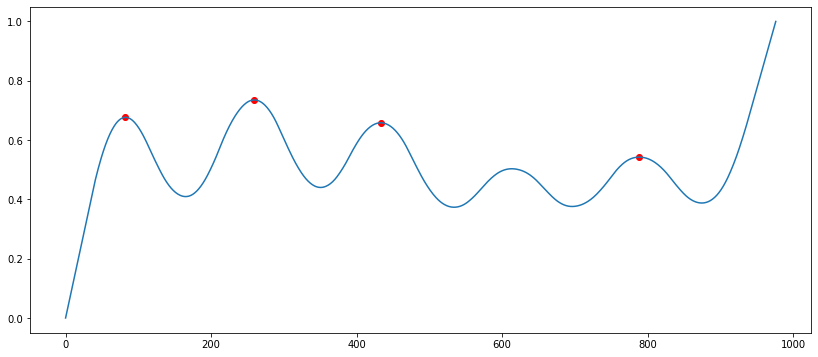

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
2100
[ 1 EPOCH latency 평균 ? ]  :  0:00:24.285000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  23.38175
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.1735578420005635
luminol 분산  :  0.03460362458319465
luminol 표준편차  :  0.18602049506222332
luminol 평균값 : 0.29714696775448163
luminol 중앙값 : 0.2800147267953801


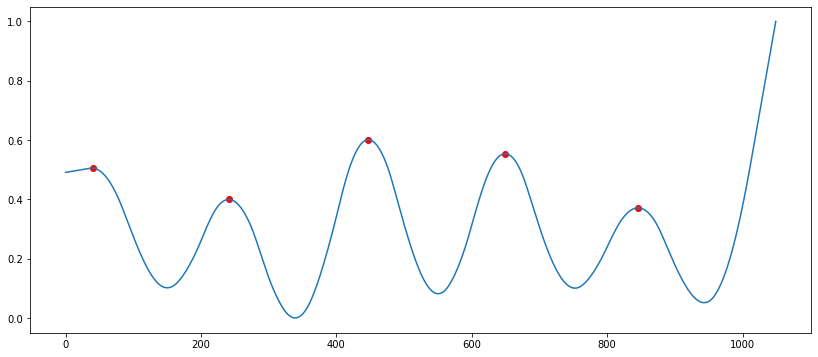

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1550
[ 1 EPOCH latency 평균 ? ]  :  0:00:18.044400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  16.59825
클러스터 레이블 : 
[0 1 2 3 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.8136511181898759
luminol 분산  :  0.04375742733640295
luminol 표준편차  :  0.20918276060995789
luminol 평균값 : 0.2474771187898619
luminol 중앙값 : 0.17189385105162638


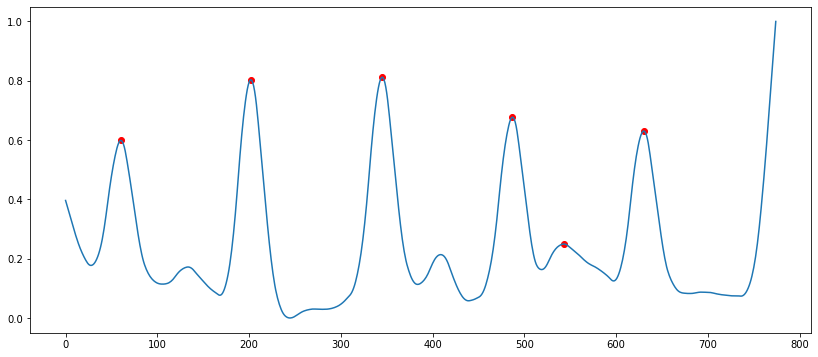

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1635
[ 1 EPOCH latency 평균 ? ]  :  0:00:19.113100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  26.5265
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  1.1868645744875435
luminol 분산  :  0.025217069871609724
luminol 표준편차  :  0.15879883460406669
luminol 평균값 : 0.16873290918457662
luminol 중앙값 : 0.1378402967474125


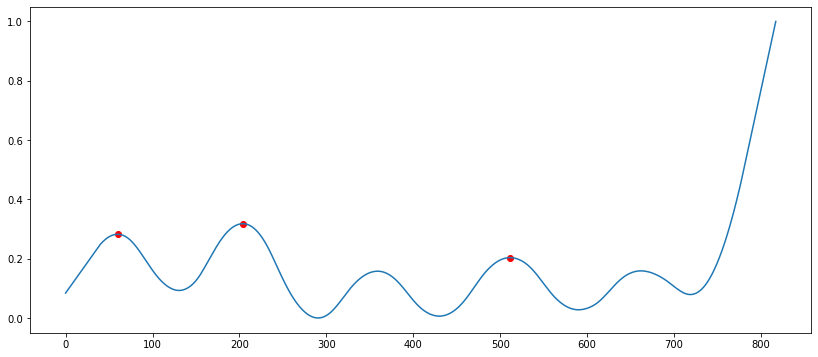

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1130
[ 1 EPOCH latency 평균 ? ]  :  0:00:13.117800
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  11.56975
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7945281806021717
luminol 분산  :  0.03183293110622851
luminol 표준편차  :  0.1784178553458944
luminol 평균값 : 0.18467336161877781
luminol 중앙값 : 0.09387416628246185


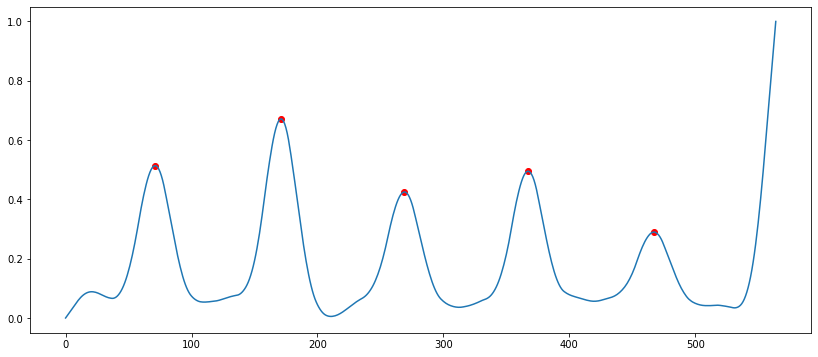

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize256_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1737
[ 1 EPOCH latency 평균 ? ]  :  0:00:20.282000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  21.18733333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.728836964747169
luminol 분산  :  0.03144253088322234
luminol 표준편차  :  0.17732041868668802
luminol 평균값 : 0.27641211405763516
luminol 중앙값 : 0.23392887207528698


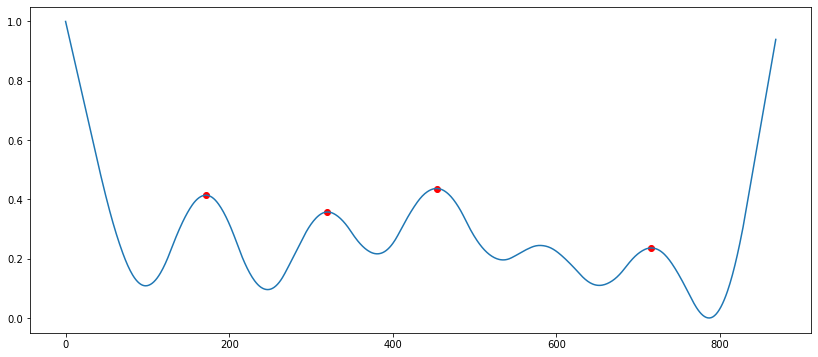

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1999
[ 1 EPOCH latency 평균 ? ]  :  0:00:23.260100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  21.646
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.8496208098123974
luminol 분산  :  0.03352698472744796
luminol 표준편차  :  0.18310375399605536
luminol 평균값 : 0.30479513324398605
luminol 중앙값 : 0.28576249754661354


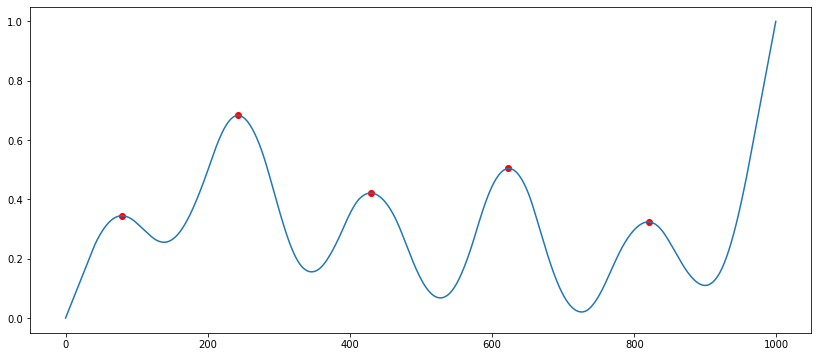

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1334
[ 1 EPOCH latency 평균 ? ]  :  0:00:15.727400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  14.5645
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.5275482077754765
luminol 분산  :  0.031061195921305414
luminol 표준편차  :  0.1762418676742431
luminol 평균값 : 0.17489870222266402
luminol 중앙값 : 0.11256717047305775


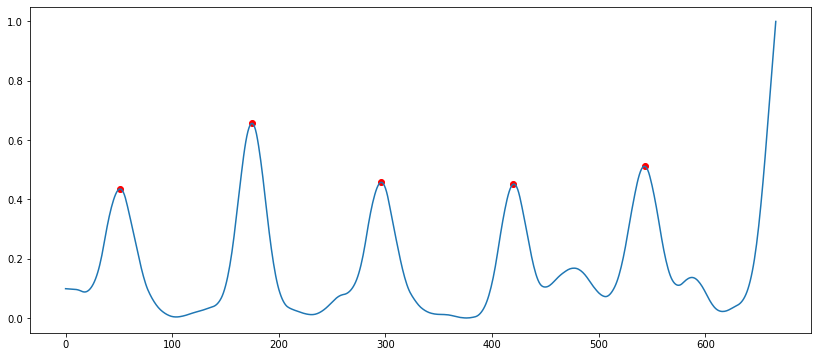

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionV3_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1168
[ 1 EPOCH latency 평균 ? ]  :  0:00:13.648900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  12.3635
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.1345677574545758
luminol 분산  :  0.03574241837788431
luminol 표준편차  :  0.18905665388418444
luminol 평균값 : 0.19489049428775745
luminol 중앙값 : 0.10590263529205302


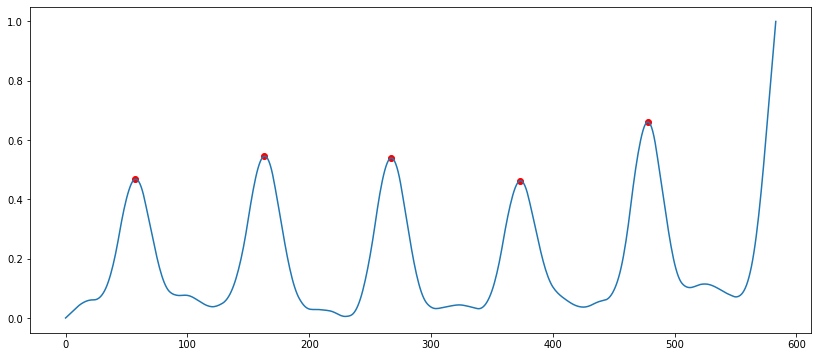

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
InceptionV3*
mae
2.218383333333333
rsme
2.84690201402459
mape
12.125912460020075
r2
0.38663763657375716
-----------------------------------------------------------------
VGG19*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize16_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1265
[ 1 EPOCH latency 평균 ? ]  :  0:00:14.732900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  14.20575
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.722776806173691
luminol 분산  :  0.033635218323509485
luminol 표준편차  :  0.1833990684913898
luminol 평균값 : 0.3681208568135279
luminol 중앙값 : 0.27568586137896206


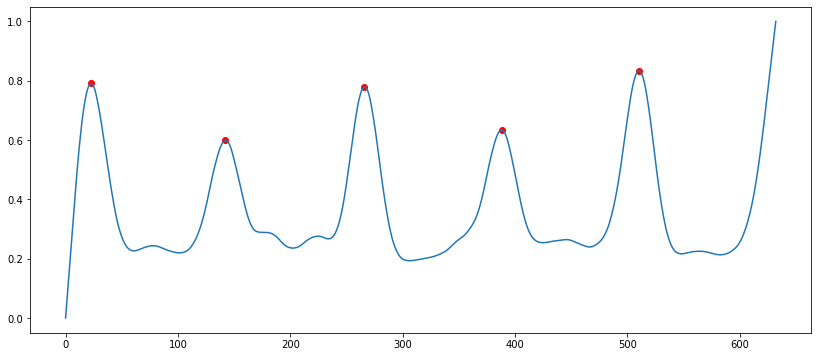

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3102
[ 1 EPOCH latency 평균 ? ]  :  0:00:36.285500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  32.70725
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.4765508730321059
luminol 분산  :  0.04977273692484922
luminol 표준편차  :  0.2230980433012563
luminol 평균값 : 0.5754353123121144
luminol 중앙값 : 0.5605443991955269


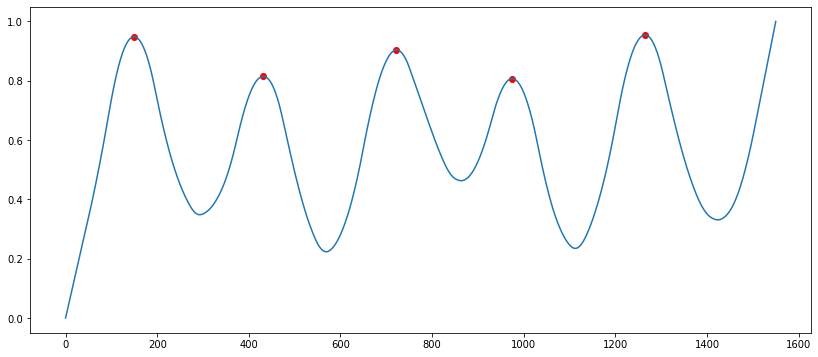

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
748
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.695600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  6.6776
클러스터 레이블 : 
[0 1 2 3 4 5]
클러스터 갯수 : 5
sum 데이터 분산  :  1.763793711264882
luminol 분산  :  0.020798963848855854
luminol 표준편차  :  0.14421845876605344
luminol 평균값 : 0.32163709112523403
luminol 중앙값 : 0.3065891219366087


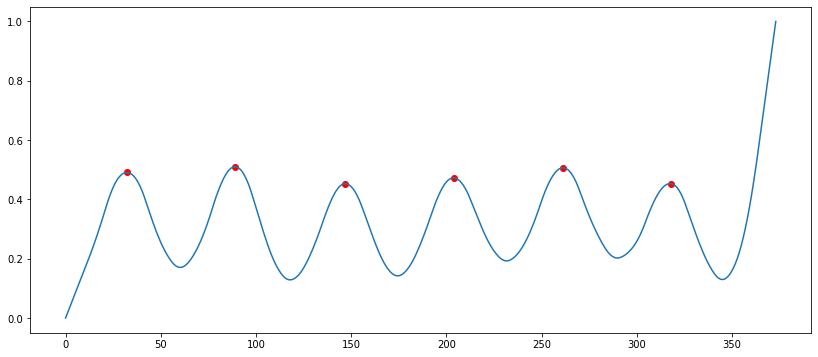

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3648
[ 1 EPOCH latency 평균 ? ]  :  0:00:42.725200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  35.50125
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.4151178342030723
luminol 분산  :  0.019074662631545745
luminol 표준편차  :  0.13811105180812194
luminol 평균값 : 0.14606181618103667
luminol 중앙값 : 0.11222669003480176


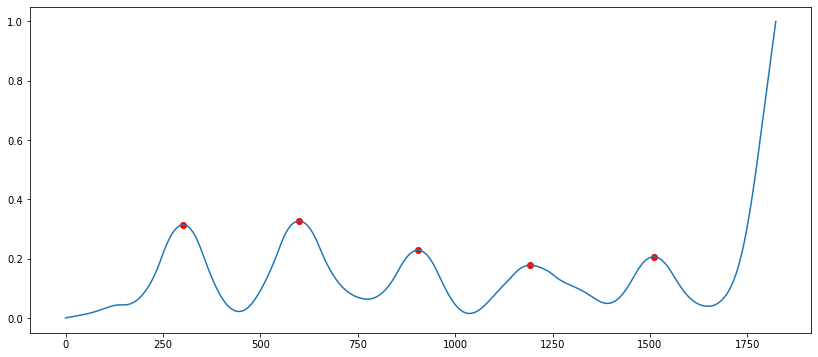

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize128_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
2412
[ 1 EPOCH latency 평균 ? ]  :  0:00:28.185700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.052
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  0.6201585050736782
luminol 분산  :  0.03448986485131916
luminol 표준편차  :  0.1857144713029094
luminol 평균값 : 0.23124785416472227
luminol 중앙값 : 0.17470341841072914


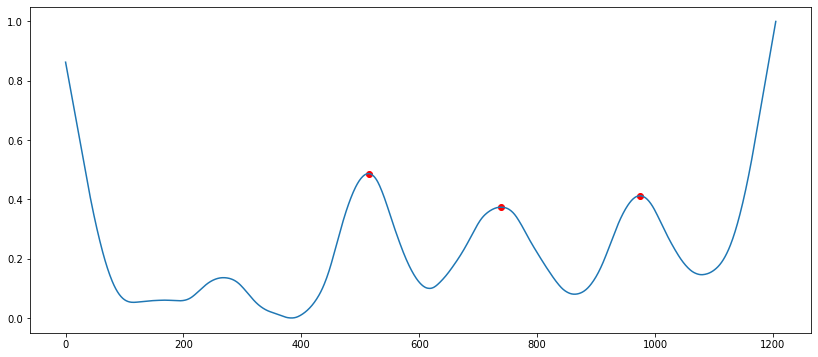

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
2067
[ 1 EPOCH latency 평균 ? ]  :  0:00:24.269400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  22.552000000000003
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.0382984749399984
luminol 분산  :  0.03292268092262783
luminol 표준편차  :  0.18144608268746898
luminol 평균값 : 0.23791772088025237
luminol 중앙값 : 0.22110131271057706


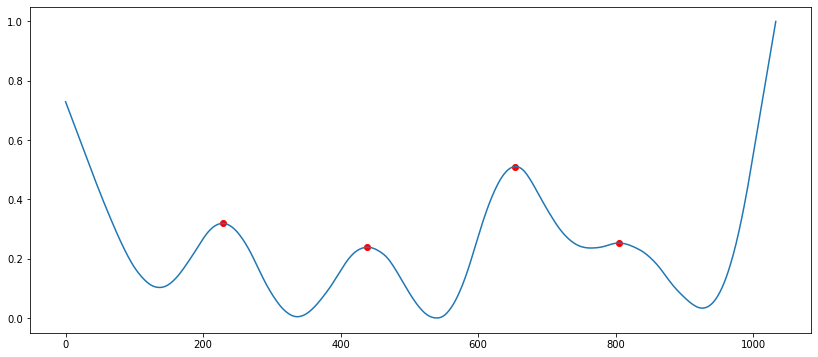

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3065
[ 1 EPOCH latency 평균 ? ]  :  0:00:36.134100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  43.97833333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.6030868842306023
luminol 분산  :  0.021913238178753063
luminol 표준편차  :  0.14803120677327825
luminol 평균값 : 0.38756208282220556
luminol 중앙값 : 0.3558516710813272


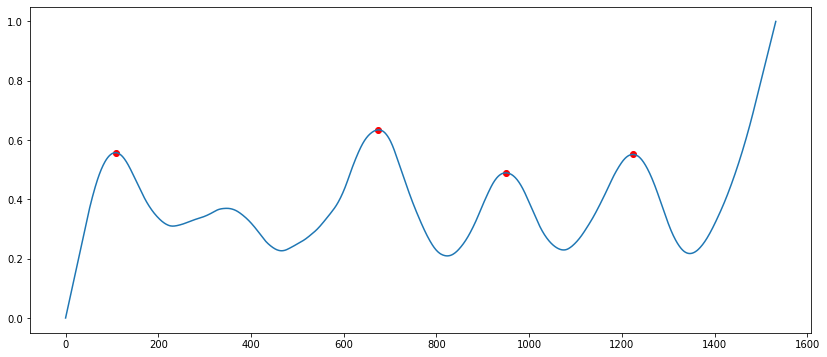

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3078
[ 1 EPOCH latency 평균 ? ]  :  0:00:36.073100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  35.02233333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.5899053367943292
luminol 분산  :  0.050763920765729144
luminol 표준편차  :  0.22530850131703672
luminol 평균값 : 0.4079366787252476
luminol 중앙값 : 0.3784622613548578


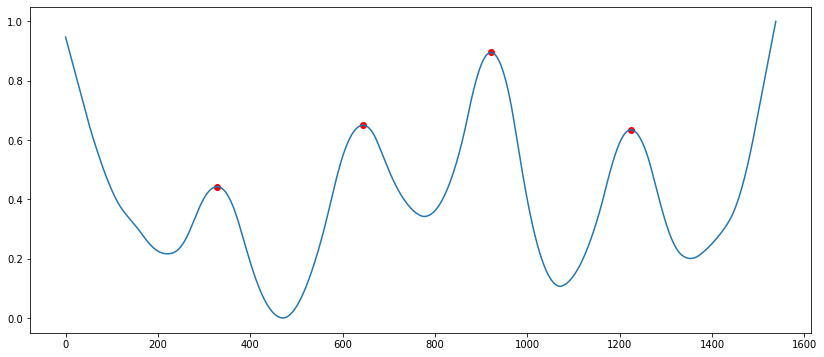

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2796
[ 1 EPOCH latency 평균 ? ]  :  0:00:32.534400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  32.37466666666666
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.9542540708355636
luminol 분산  :  0.025920954001326716
luminol 표준편차  :  0.160999857146914
luminol 평균값 : 0.22143229447223367
luminol 중앙값 : 0.19252729832824755


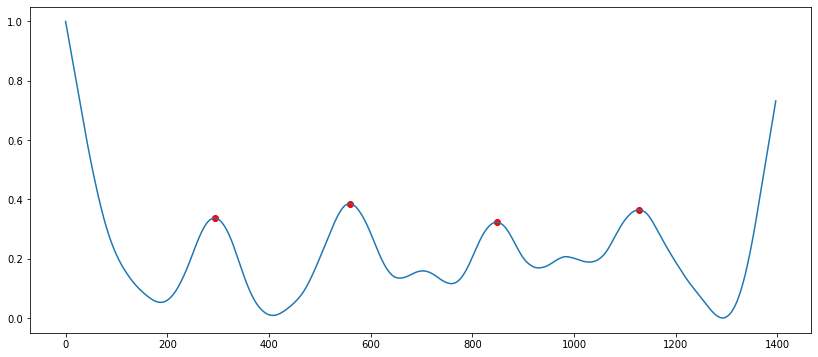

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2776
[ 1 EPOCH latency 평균 ? ]  :  0:00:32.384300
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.774
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.4447774675675255
luminol 분산  :  0.018946648348574128
luminol 표준편차  :  0.13764682469484768
luminol 평균값 : 0.14980009504436664
luminol 중앙값 : 0.11939749588078771


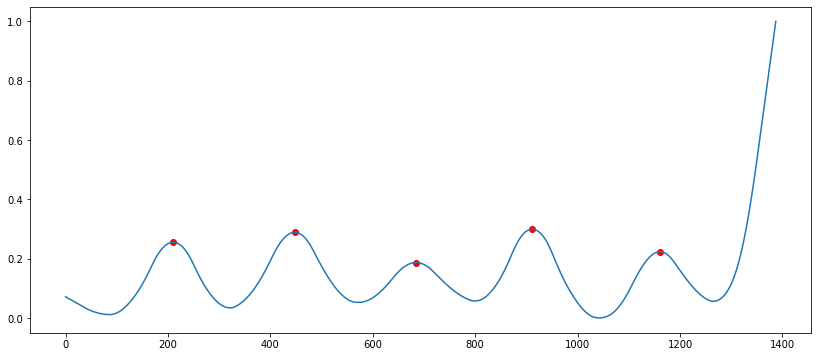

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize32_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
4924
[ 1 EPOCH latency 평균 ? ]  :  0:00:57.379500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  57.186
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  1.4787308609568588
luminol 분산  :  0.029793699982031602
luminol 표준편차  :  0.1726085165396876
luminol 평균값 : 0.23406803373014165
luminol 중앙값 : 0.19574393160391806


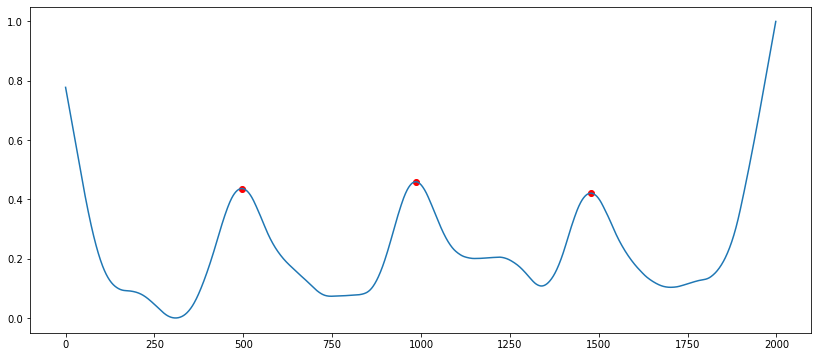

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2332
[ 1 EPOCH latency 평균 ? ]  :  0:00:27.293500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  25.700999999999997
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.5593290448887132
luminol 분산  :  0.04932426628382784
luminol 표준편차  :  0.2220906713120293
luminol 평균값 : 0.3236629631986217
luminol 중앙값 : 0.2851657224122879


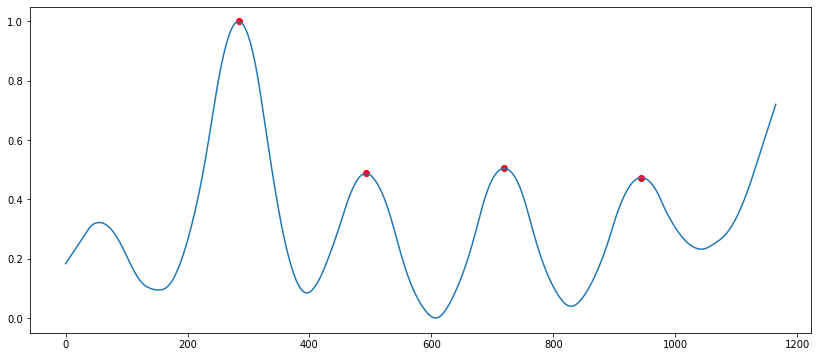

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
3264
[ 1 EPOCH latency 평균 ? ]  :  0:00:38.017400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  38.125
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.4295736355548387
luminol 분산  :  0.02680457399548796
luminol 표준편차  :  0.1637210249036084
luminol 평균값 : 0.20533121793826514
luminol 중앙값 : 0.16634510555177373


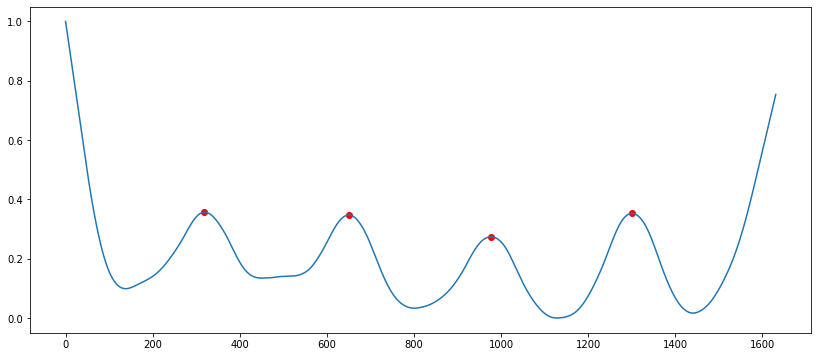

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2384
[ 1 EPOCH latency 평균 ? ]  :  0:00:27.871000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  33.39066666666667
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.4958320592595781
luminol 분산  :  0.026589233328700092
luminol 표준편차  :  0.16306205361364762
luminol 평균값 : 0.4102761483261632
luminol 중앙값 : 0.38200254802805406


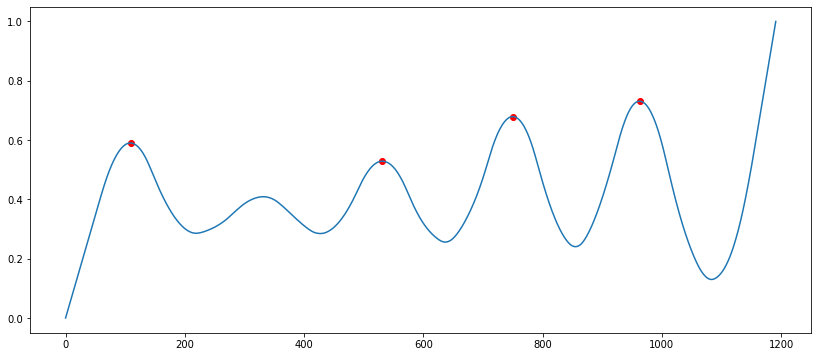

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2426
[ 1 EPOCH latency 평균 ? ]  :  0:00:28.428900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.376333333333335
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.9474592713447249
luminol 분산  :  0.03830135508053148
luminol 표준편차  :  0.19570731994621837
luminol 평균값 : 0.3226401493598942
luminol 중앙값 : 0.3053674572877765


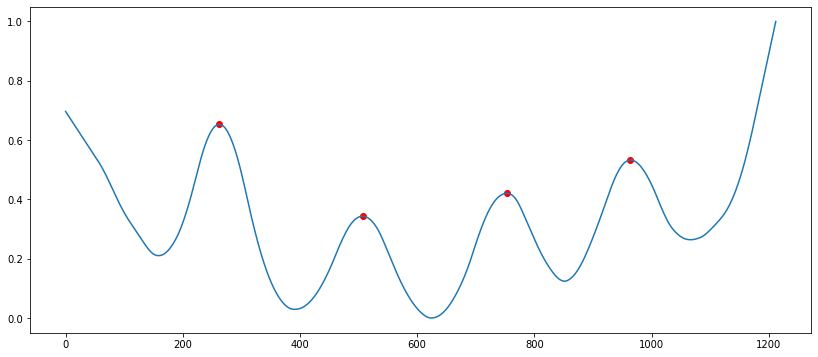

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3722
[ 1 EPOCH latency 평균 ? ]  :  0:00:43.710900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  42.33
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.378852232743704
luminol 분산  :  0.03078446589789196
luminol 표준편차  :  0.17545502528537607
luminol 평균값 : 0.17737707100434583
luminol 중앙값 : 0.12902930491513515


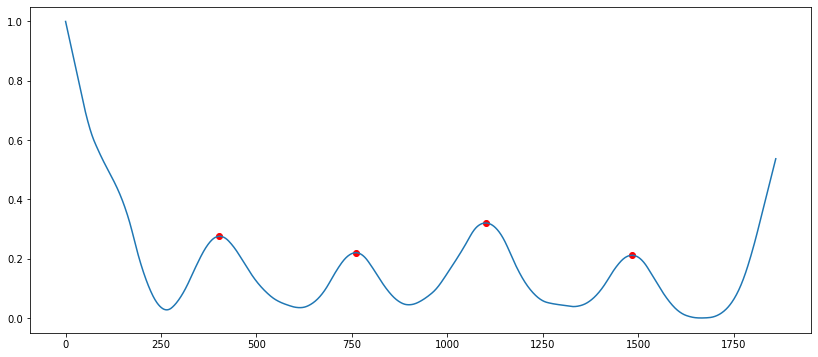

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
8280
[ 1 EPOCH latency 평균 ? ]  :  0:01:36.232600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  48.208666666666666
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.210222734044586
luminol 분산  :  0.053679976452855126
luminol 표준편차  :  0.23168939650500867
luminol 평균값 : 0.4124505471436808
luminol 중앙값 : 0.363494611672807


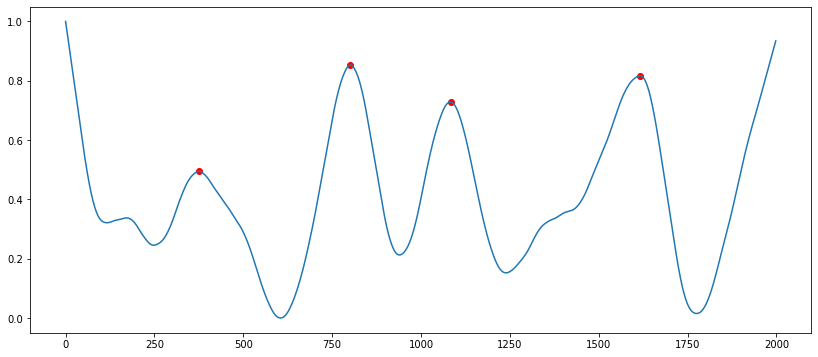

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
906
[ 1 EPOCH latency 평균 ? ]  :  0:00:10.523600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  10.008
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.2097503576822513
luminol 분산  :  0.028185242706339906
luminol 표준편차  :  0.16788461128507254
luminol 평균값 : 0.44733828972998463
luminol 중앙값 : 0.38214331864449935


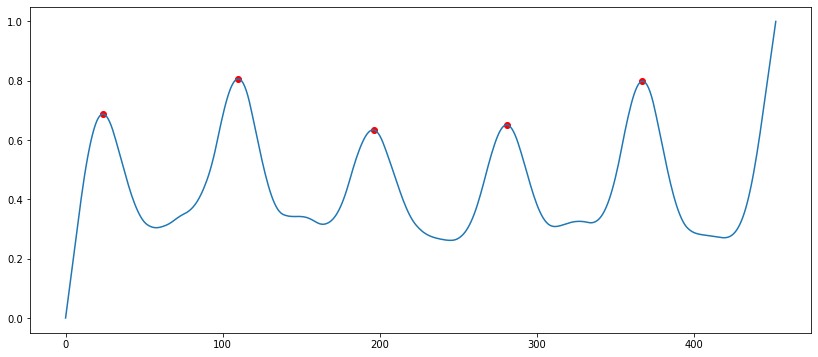

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3790
[ 1 EPOCH latency 평균 ? ]  :  0:00:44.408700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  56.718333333333334
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.4545292181113457
luminol 분산  :  0.059625009221874276
luminol 표준편차  :  0.2441823278246693
luminol 평균값 : 0.3168246839641083
luminol 중앙값 : 0.2419953021374542


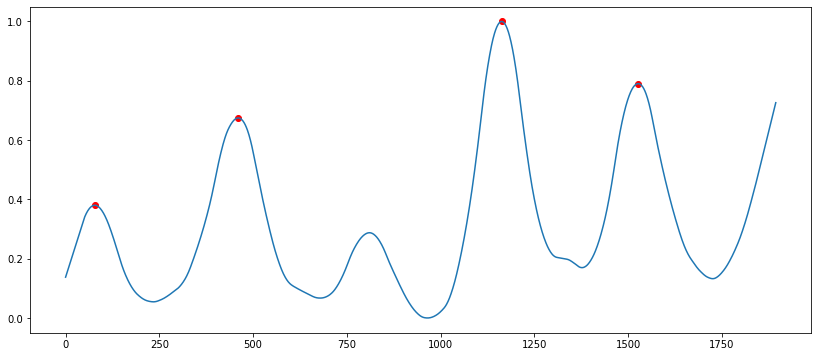

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
737
[ 1 EPOCH latency 평균 ? ]  :  0:00:08.549200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  7.89775
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.7231409293981483
luminol 분산  :  0.03104066747652818
luminol 표준편차  :  0.1761836186384199
luminol 평균값 : 0.26019161379852185
luminol 중앙값 : 0.22963314482301345


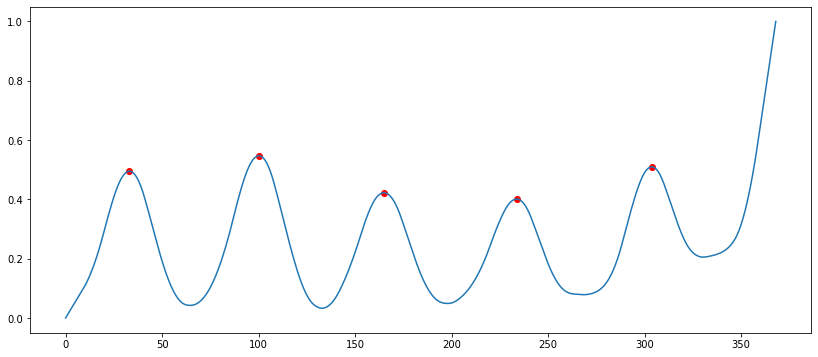

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize64_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
4150
[ 1 EPOCH latency 평균 ? ]  :  0:00:48.530400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  44.3565
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.2595002030842049
luminol 분산  :  0.04917604944804587
luminol 표준편차  :  0.22175673484258798
luminol 평균값 : 0.4607988784803388
luminol 중앙값 : 0.40391847215245735


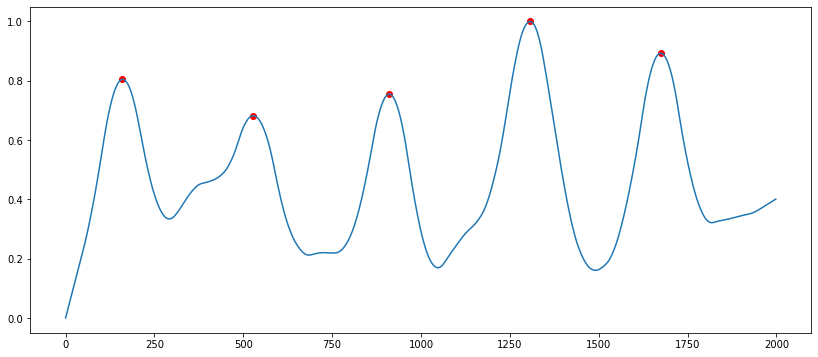

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/VGG19_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
680
[ 1 EPOCH latency 평균 ? ]  :  0:00:07.957200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  6.9265
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.120067539006394
luminol 분산  :  0.030068296283913745
luminol 표준편차  :  0.1734021230663389
luminol 평균값 : 0.22551893313939808
luminol 중앙값 : 0.19684575338672894


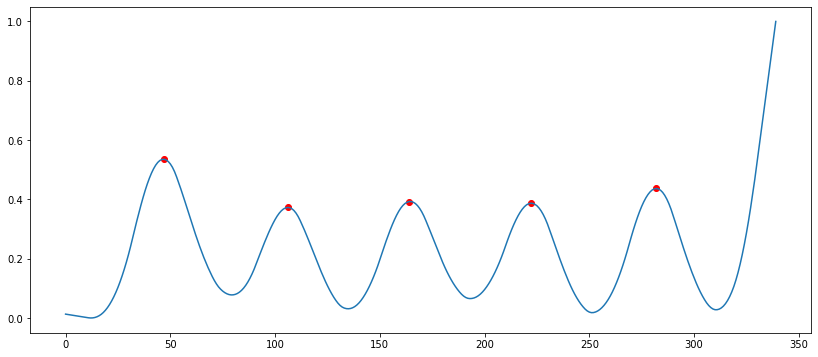

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
VGG19*
mae
4.8370651515151515
rsme
11.01766474550957
mape
11.30995122416739
r2
0.6687408640548406
-----------------------------------------------------------------
ResNet50*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize16_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1244
[ 1 EPOCH latency 평균 ? ]  :  0:00:14.690800
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  13.881
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.079897912899099
luminol 분산  :  0.04412545709337123
luminol 표준편차  :  0.21006060338238397
luminol 평균값 : 0.3033893571647319
luminol 중앙값 : 0.19216595191022093


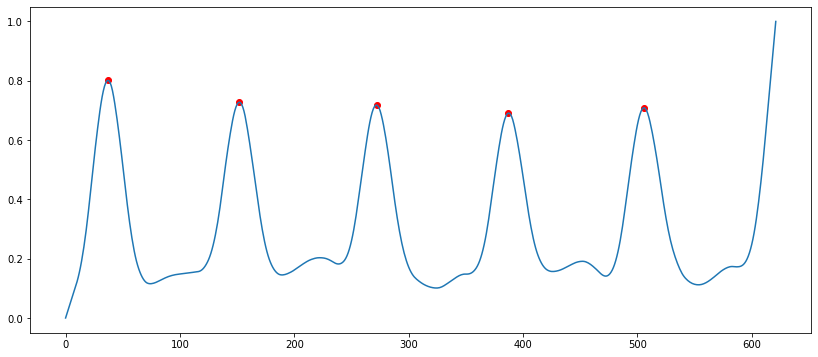

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1608
[ 1 EPOCH latency 평균 ? ]  :  0:00:18.841600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  23.02333333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.6698097925431215
luminol 분산  :  0.025187714469028365
luminol 표준편차  :  0.158706378161145
luminol 평균값 : 0.19205586421152696
luminol 중앙값 : 0.1715332901132287


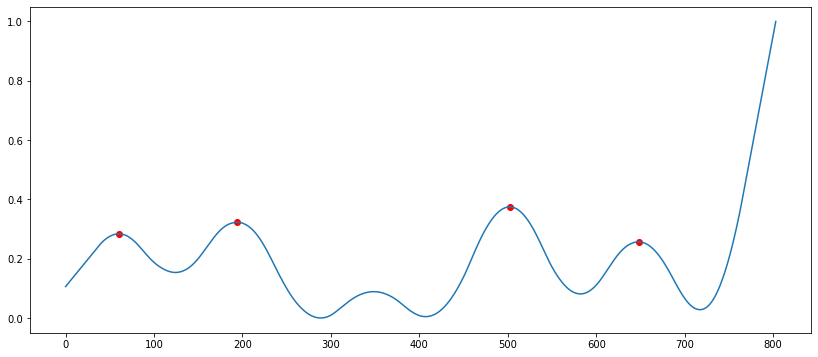

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
557
[ 1 EPOCH latency 평균 ? ]  :  0:00:06.502900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  8.0735
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  0.3580690280690794
luminol 분산  :  0.02169156213882469
luminol 표준편차  :  0.14728055587491748
luminol 평균값 : 0.07063177244578404
luminol 중앙값 : 0.03628718879122133


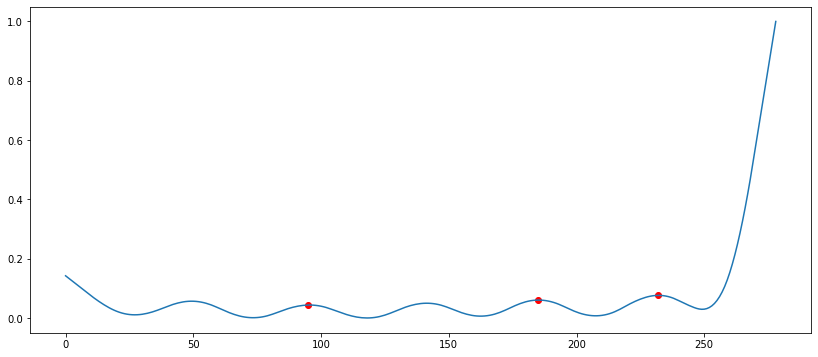

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
2047
[ 1 EPOCH latency 평균 ? ]  :  0:00:23.974900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  23.035
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.4189480019651046
luminol 분산  :  0.027706258797804677
luminol 표준편차  :  0.16645197144463228
luminol 평균값 : 0.24806567966463408
luminol 중앙값 : 0.2247783895454157


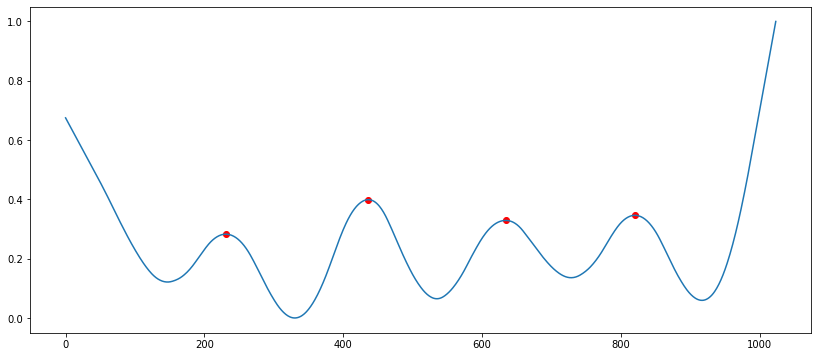

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize32_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
5635
[ 1 EPOCH latency 평균 ? ]  :  0:01:06.378500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  43.411
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  2.2081162127167753
luminol 분산  :  0.01998156815329527
luminol 표준편차  :  0.14135617479719545
luminol 평균값 : 0.1810507340449817
luminol 중앙값 : 0.14780469776106592


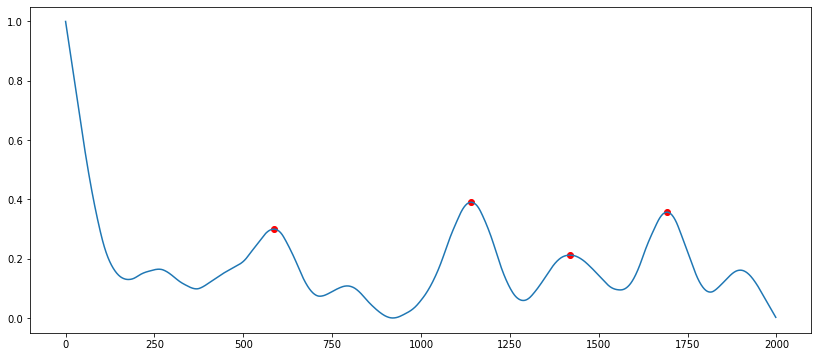

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize128_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
2235
[ 1 EPOCH latency 평균 ? ]  :  0:00:25.890500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  24.74475
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.2402790759985134
luminol 분산  :  0.07130608059540432
luminol 표준편차  :  0.26703198421800395
luminol 평균값 : 0.43788473328216604
luminol 중앙값 : 0.4204484632891274


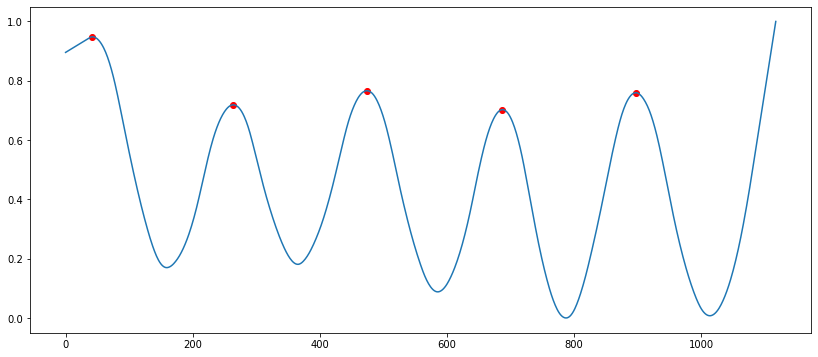

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
634
[ 1 EPOCH latency 평균 ? ]  :  0:00:07.328700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  6.367
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.651457705119862
luminol 분산  :  0.036916710253342255
luminol 표준편차  :  0.19213721725200003
luminol 평균값 : 0.3314301741426607
luminol 중앙값 : 0.31053202332598556


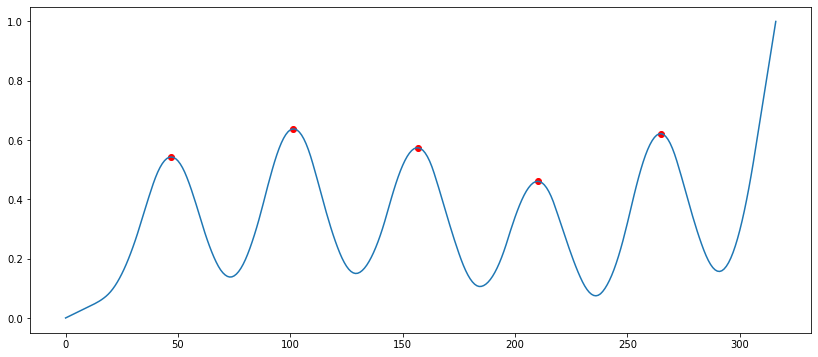

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1598
[ 1 EPOCH latency 평균 ? ]  :  0:00:18.632600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  16.812
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.6440834766601027
luminol 분산  :  0.023922946715094543
luminol 표준편차  :  0.15467044551269174
luminol 평균값 : 0.14351063356094554
luminol 중앙값 : 0.07568965099894315


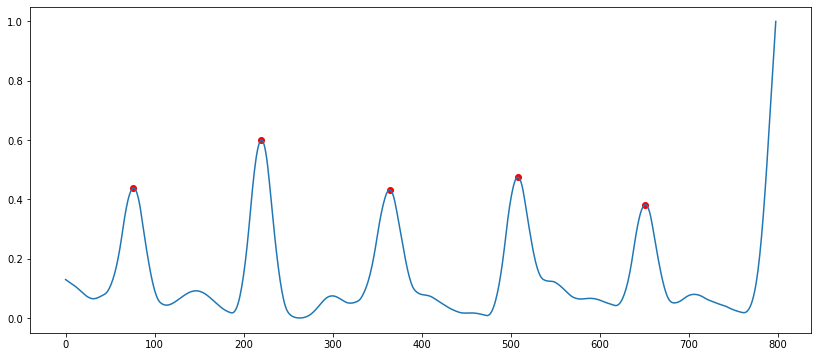

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1893
[ 1 EPOCH latency 평균 ? ]  :  0:00:22.062700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  20.21375
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7571786442400474
luminol 분산  :  0.022443256231146305
luminol 표준편차  :  0.14981073469930753
luminol 평균값 : 0.1711459437382654
luminol 중앙값 : 0.1511778425188584


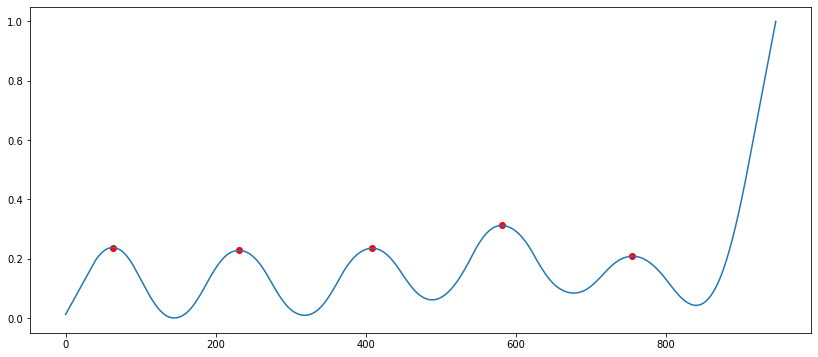

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
3133
[ 1 EPOCH latency 평균 ? ]  :  0:00:36.629500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  35.90033333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  2.125483019059854
luminol 분산  :  0.036040630147084265
luminol 표준편차  :  0.1898436992556884
luminol 평균값 : 0.24032602112247356
luminol 중앙값 : 0.19930022898378794


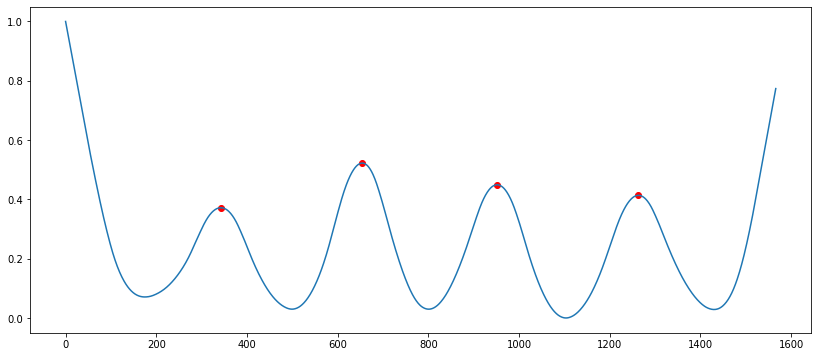

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1558
[ 1 EPOCH latency 평균 ? ]  :  0:00:18.179400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  16.86575
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7441413934289985
luminol 분산  :  0.011045418942652029
luminol 표준편차  :  0.10509718808156586
luminol 평균값 : 0.1603108825666642
luminol 중앙값 : 0.13528544500676556


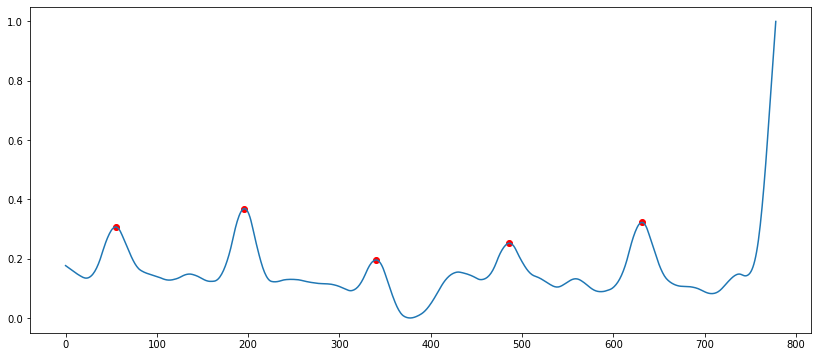

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
1672
[ 1 EPOCH latency 평균 ? ]  :  0:00:19.647400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  18.25466666666667
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.7520390075095096
luminol 분산  :  0.02962253979538571
luminol 표준편차  :  0.1721119978252118
luminol 평균값 : 0.2560717128118409
luminol 중앙값 : 0.24811165519866005


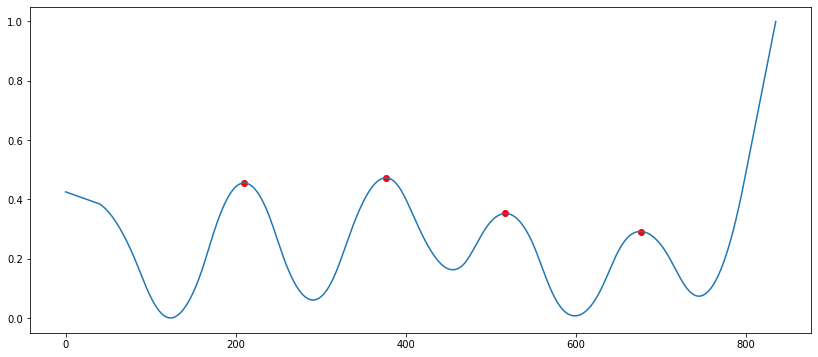

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
1752
[ 1 EPOCH latency 평균 ? ]  :  0:00:20.921900
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  19.485666666666667
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.420997272710927
luminol 분산  :  0.04721470244767621
luminol 표준편차  :  0.21728944393982008
luminol 평균값 : 0.430688665366395
luminol 중앙값 : 0.4311131089975014


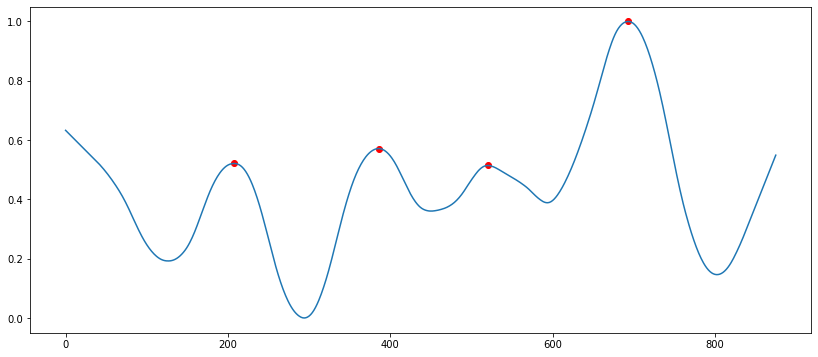

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
9742
[ 1 EPOCH latency 평균 ? ]  :  0:01:55.318400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  49.661
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  1.7117500029063064
luminol 분산  :  0.06191153452577451
luminol 표준편차  :  0.24882028559941513
luminol 평균값 : 0.39145210123702917
luminol 중앙값 : 0.33257126052560027


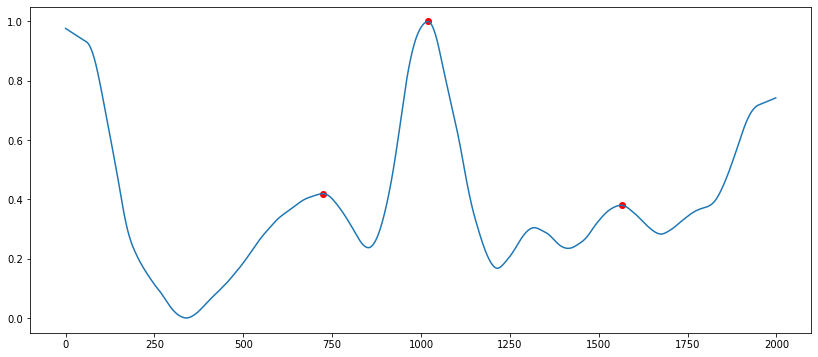

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
556
[ 1 EPOCH latency 평균 ? ]  :  0:00:06.529000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  5.01575
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.9219289187432218
luminol 분산  :  0.028700929750536664
luminol 표준편차  :  0.16941348751069574
luminol 평균값 : 0.5868530737026413
luminol 중앙값 : 0.5708287350217616


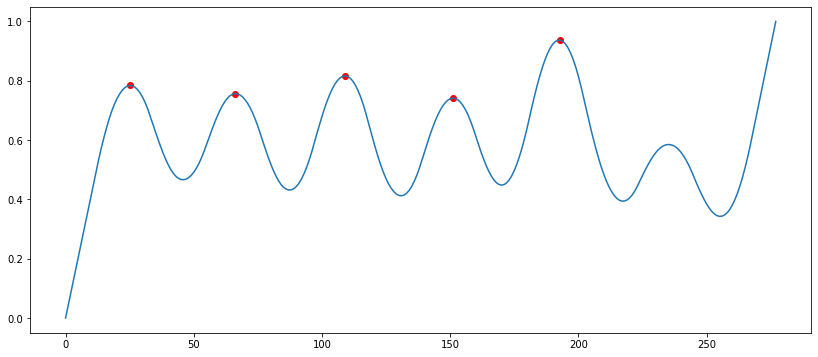

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
2472
[ 1 EPOCH latency 평균 ? ]  :  0:00:29.078100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.953666666666667
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.7580210069045028
luminol 분산  :  0.0276561440711758
luminol 표준편차  :  0.16630136521140107
luminol 평균값 : 0.2413118671609094
luminol 중앙값 : 0.21613219472115006


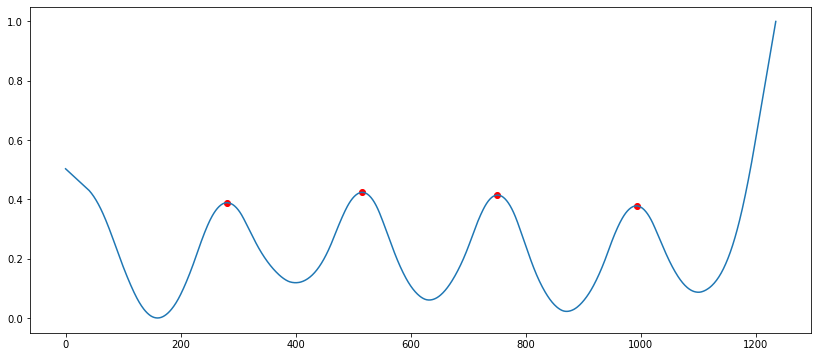

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2119
[ 1 EPOCH latency 평균 ? ]  :  0:00:24.634100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  23.734666666666666
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.6088360749530652
luminol 분산  :  0.02644856712694824
luminol 표준편차  :  0.16263015442084608
luminol 평균값 : 0.2668410033444643
luminol 중앙값 : 0.25603221610427346


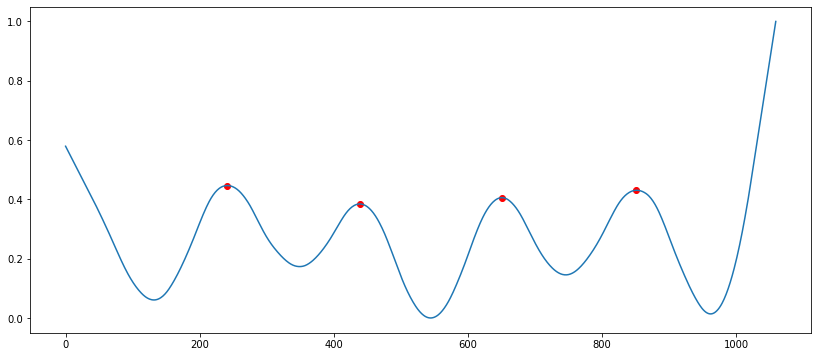

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1963
[ 1 EPOCH latency 평균 ? ]  :  0:00:22.926600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  21.102333333333334
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.6052070530811228
luminol 분산  :  0.01886029652837531
luminol 표준편차  :  0.13733279480289953
luminol 평균값 : 0.3341280995704702
luminol 중앙값 : 0.30937573013586284


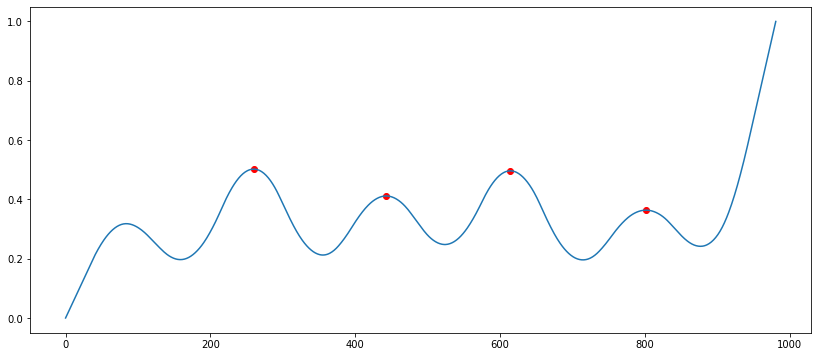

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
1935
[ 1 EPOCH latency 평균 ? ]  :  0:00:22.656700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  21.490666666666666
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.8307706838152843
luminol 분산  :  0.044219490146877725
luminol 표준편차  :  0.21028430789499658
luminol 평균값 : 0.30753472726683145
luminol 중앙값 : 0.2809168770683716


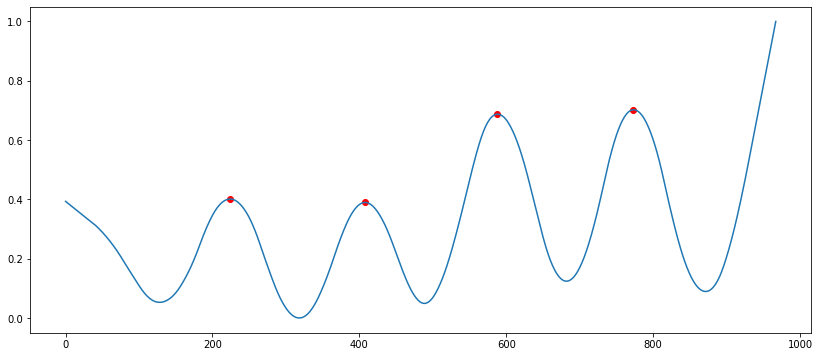

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
816
[ 1 EPOCH latency 평균 ? ]  :  0:00:09.580400
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  8.599
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.2195854330605256
luminol 분산  :  0.035391018633031825
luminol 표준편차  :  0.1881250079947688
luminol 평균값 : 0.28829199687008716
luminol 중앙값 : 0.23130664776292023


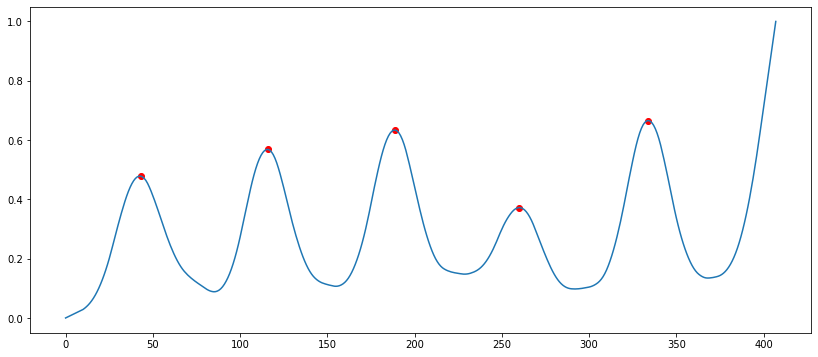

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNet50_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
2369
[ 1 EPOCH latency 평균 ? ]  :  0:00:27.856300
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.230999999999998
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  0.6507165422794362
luminol 분산  :  0.027807470736087546
luminol 표준편차  :  0.1667557217491728
luminol 평균값 : 0.16877314242234315
luminol 중앙값 : 0.11749251779325555


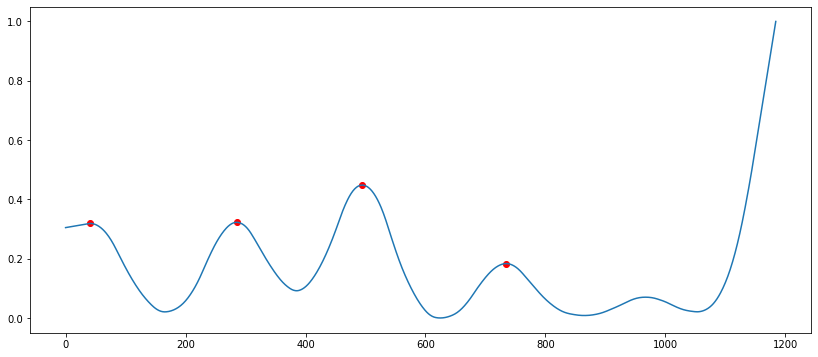

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
ResNet50*
mae
5.471896825396824
rsme
15.252679272901878
mape
12.498691263198129
r2
0.5754392064060307
-----------------------------------------------------------------
InceptionResNetV2*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize64_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
4558
[ 1 EPOCH latency 평균 ? ]  :  0:00:52.891000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  49.838
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.4464083340444807
luminol 분산  :  0.055778449294915926
luminol 표준편차  :  0.2361746161104447
luminol 평균값 : 0.4509837982294711
luminol 중앙값 : 0.3626081711353098


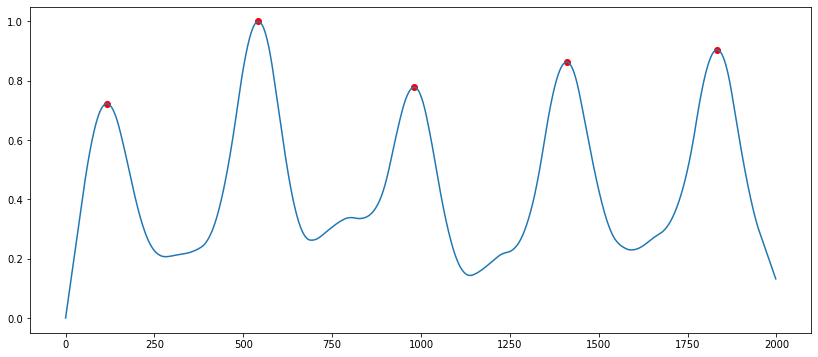

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2540
[ 1 EPOCH latency 평균 ? ]  :  0:00:29.509000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.21875
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.5880062223800375
luminol 분산  :  0.024815830667359214
luminol 표준편차  :  0.15753041188087846
luminol 평균값 : 0.35335255579202424
luminol 중앙값 : 0.3248223328746924


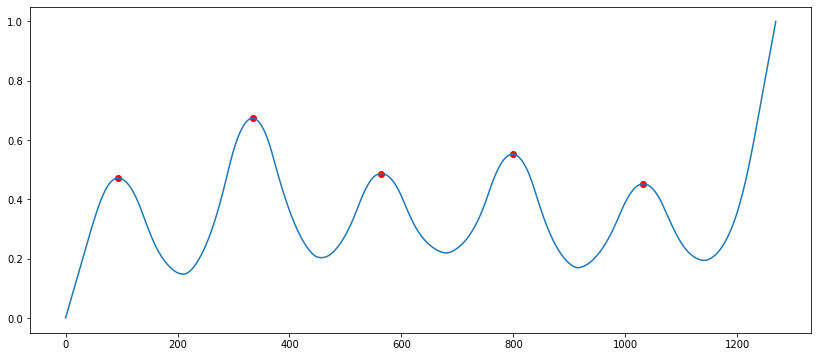

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2550
[ 1 EPOCH latency 평균 ? ]  :  0:00:29.493500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  27.03975
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.6009149672590013
luminol 분산  :  0.018872322255939426
luminol 표준편차  :  0.13737657098624723
luminol 평균값 : 0.33913244606223997
luminol 중앙값 : 0.31203202933022606


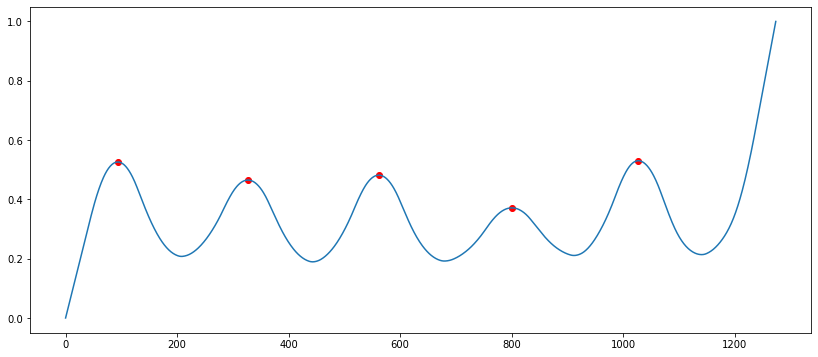

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3596
[ 1 EPOCH latency 평균 ? ]  :  0:00:41.651200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  39.26825
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.6581601045373161
luminol 분산  :  0.016355157279530647
luminol 표준편차  :  0.12788728349421863
luminol 평균값 : 0.35577292472380345
luminol 중앙값 : 0.3288196330833878


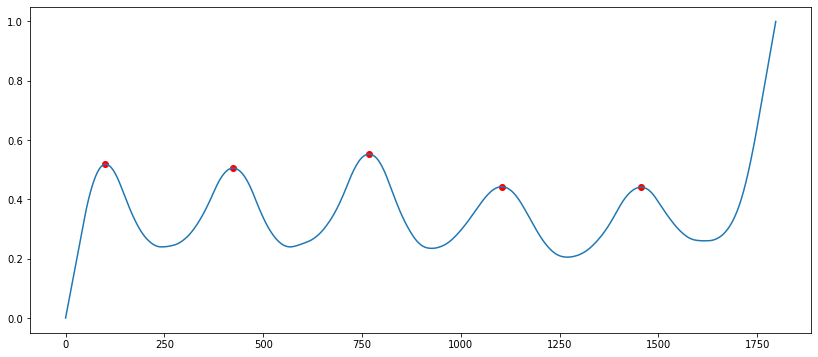

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
4861
[ 1 EPOCH latency 평균 ? ]  :  0:00:56.907000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  46.6345
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.7599213186776326
luminol 분산  :  0.056963251775223336
luminol 표준편차  :  0.23866975463016535
luminol 평균값 : 0.3963099407451884
luminol 중앙값 : 0.3691548128974578


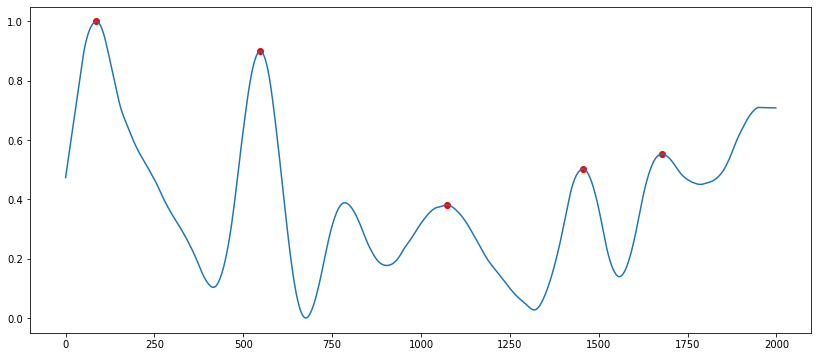

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3784
[ 1 EPOCH latency 평균 ? ]  :  0:00:44.170600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  42.01025
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.1712163040263492
luminol 분산  :  0.06163195998118864
luminol 표준편차  :  0.2482578497876525
luminol 평균값 : 0.3951723414069825
luminol 중앙값 : 0.3344621568819035


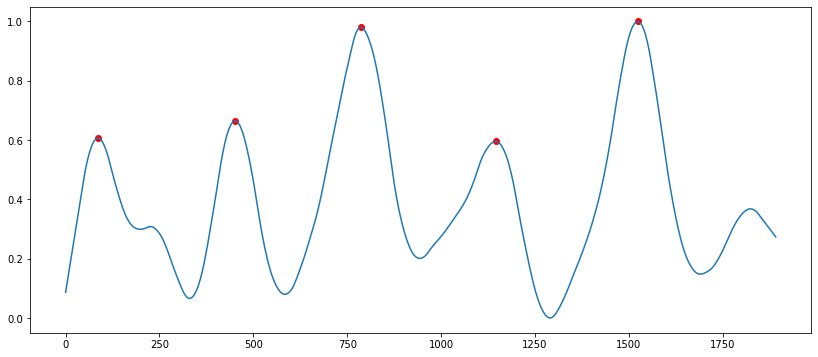

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
4213
[ 1 EPOCH latency 평균 ? ]  :  0:00:49.351800
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  80.4835
클러스터 레이블 : 
[0 1 1 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  1.3869417126668084
luminol 분산  :  0.057953123599317764
luminol 표준편차  :  0.24073455007397207
luminol 평균값 : 0.4801527184232703
luminol 중앙값 : 0.40819209476544305


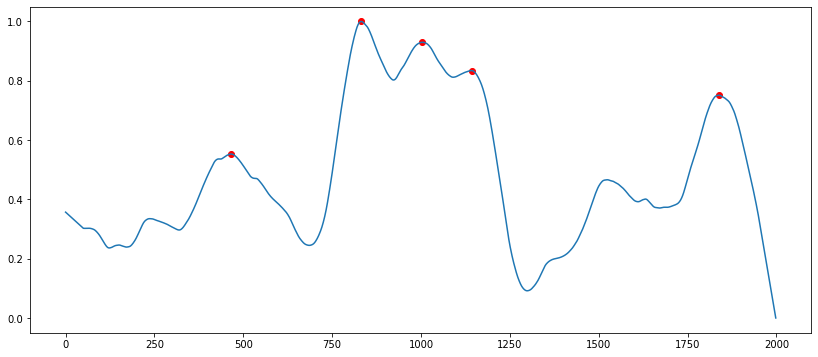

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2517
[ 1 EPOCH latency 평균 ? ]  :  0:00:29.113700
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  25.3935
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.5943708996416063
luminol 분산  :  0.042806592067922804
luminol 표준편차  :  0.2068975400238553
luminol 평균값 : 0.2707863741239031
luminol 중앙값 : 0.23729445165154417


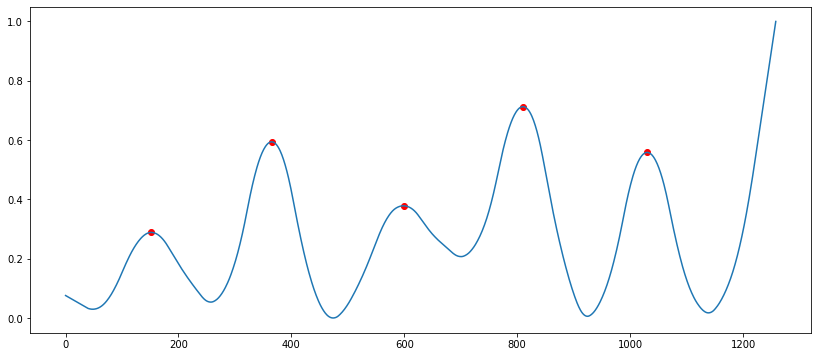

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
2834
[ 1 EPOCH latency 평균 ? ]  :  0:00:32.802200
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  30.69175
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.732468234139077
luminol 분산  :  0.03665702797702906
luminol 표준편차  :  0.1914602516895584
luminol 평균값 : 0.36259262346225124
luminol 중앙값 : 0.31402000102531563


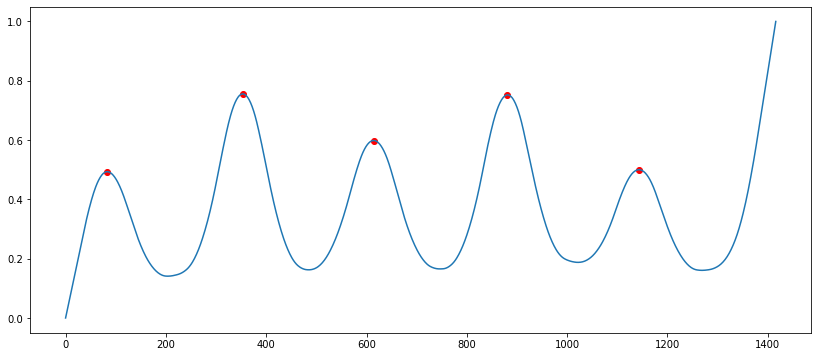

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
4587
[ 1 EPOCH latency 평균 ? ]  :  0:00:53.443600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  39.048
클러스터 레이블 : 
[0 1 2 3 4 5]
클러스터 갯수 : 5
sum 데이터 분산  :  0.741547457473081
luminol 분산  :  0.037077077263251844
luminol 표준편차  :  0.19255408918860134
luminol 평균값 : 0.44042113283017864
luminol 중앙값 : 0.420611049947508


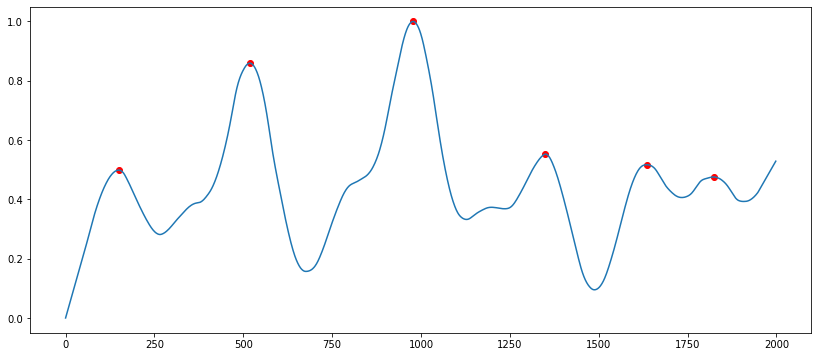

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize32_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3588
[ 1 EPOCH latency 평균 ? ]  :  0:00:41.701600
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  39.87133333333333
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  1.0165920167506581
luminol 분산  :  0.055137537952031274
luminol 표준편차  :  0.23481383679849718
luminol 평균값 : 0.5166002938421012
luminol 중앙값 : 0.472515261157953


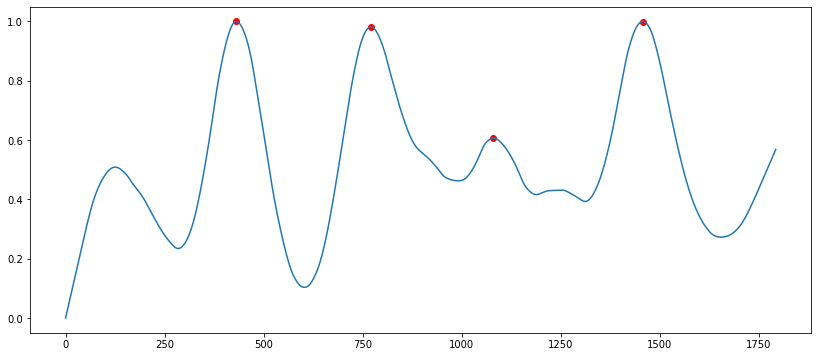

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/InceptionResNetV2_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
3657
[ 1 EPOCH latency 평균 ? ]  :  0:00:42.536500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  39.172
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  0.35611991597116477
luminol 분산  :  0.018629617033705134
luminol 표준편차  :  0.13649035509406932
luminol 평균값 : 0.1731379852131077
luminol 중앙값 : 0.14444536798451799


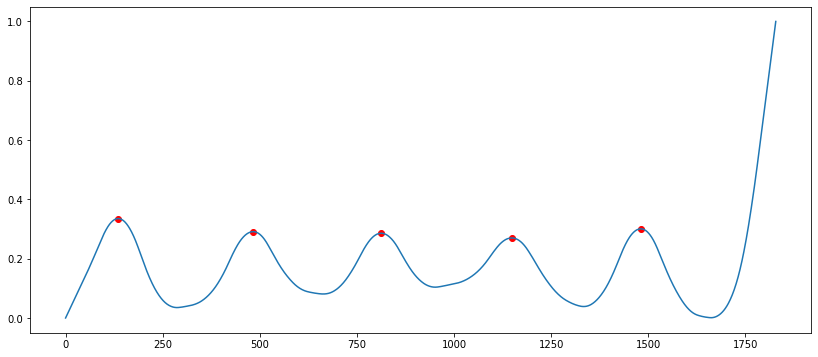

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
InceptionResNetV2*
mae
6.597126388888889
rsme
10.590233039667618
mape
14.337042035432624
r2
-0.2300560468111681
-----------------------------------------------------------------
LeNet5*
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
51
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize128_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
140
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
137
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize64_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
138
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
108
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크

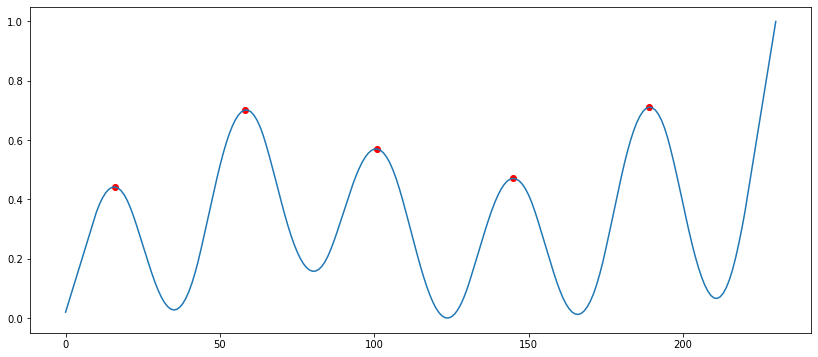

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize16_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
190
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
2660
[ 1 EPOCH latency 평균 ? ]  :  0:00:30.194000
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  33.14
클러스터 레이블 : 
[0 1 2]
클러스터 갯수 : 2
sum 데이터 분산  :  14.500059241982763
luminol 분산  :  0.06624384168280527
luminol 표준편차  :  0.25737879027380106
luminol 평균값 : 0.2885422347560048
luminol 중앙값 : 0.3464262412557903


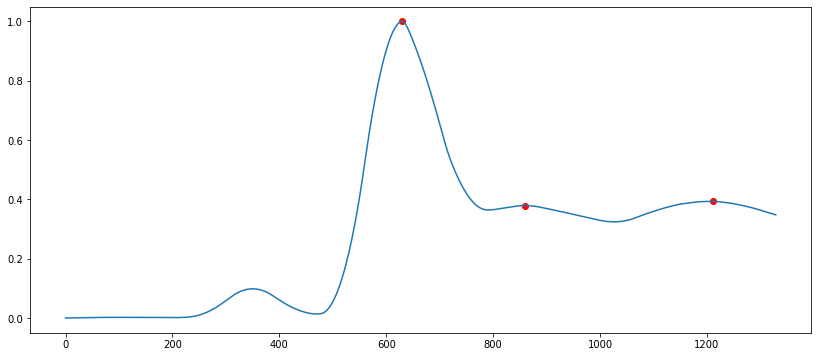

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
61
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
79
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
275
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
117
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
175
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize16_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
170
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize64_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
121
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/LeNet5_batchsize32_datasize224_total_epoch10_

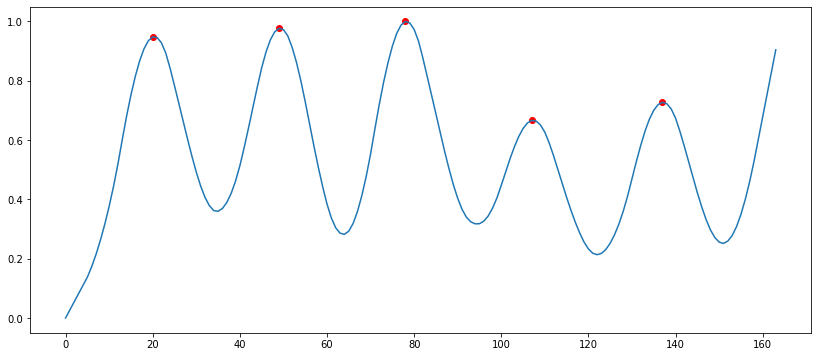

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize64_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
581
[ 1 EPOCH latency 평균 ? ]  :  0:00:06.591100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  6.20525
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.667274996648055
luminol 분산  :  0.03785148349794383
luminol 표준편차  :  0.1945545771703761
luminol 평균값 : 0.62963646480644
luminol 중앙값 : 0.621186543704103


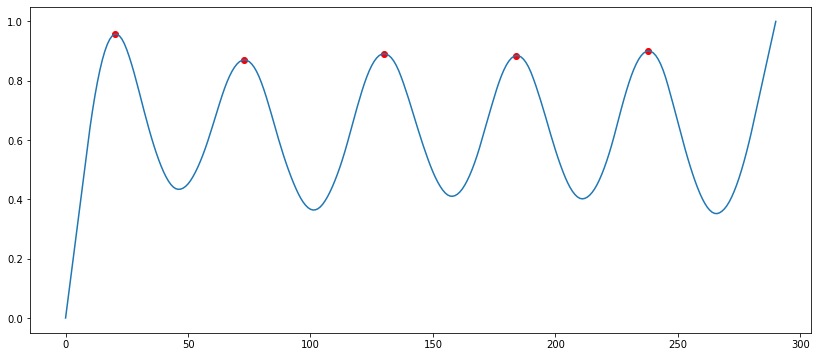

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize256_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
72
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize256_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
212
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize64_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
107
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize32_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
156
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize32_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
1062
[ 1 EPOCH latency 평균 ? ]  :  0:00:12.078500
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  11.71875
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  2.0956222498702135
luminol 분산  :  0.04504141612421631
luminol 표준편차  :  0.21222963064618547
luminol 평균값 : 0.22263938890216853
luminol 중앙값 : 0.12144068268686747


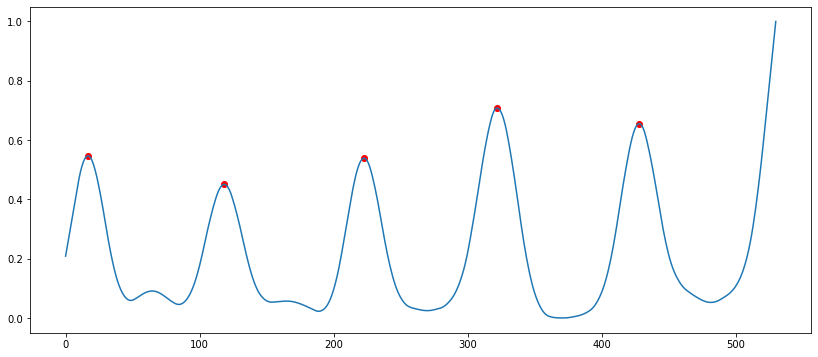

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize256_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
176
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize64_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
258
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize128_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
173
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize32_datasize128_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
225
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize16_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
252
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize16_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
1849
[ 1 EPOCH latency 평균 ? ]  :  0:00:21.024100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  20.556
클러스터 레이블 : 
[0 1 2 3]
클러스터 갯수 : 3
sum 데이터 분산  :  2.4036674413275527
luminol 분산  :  0.0

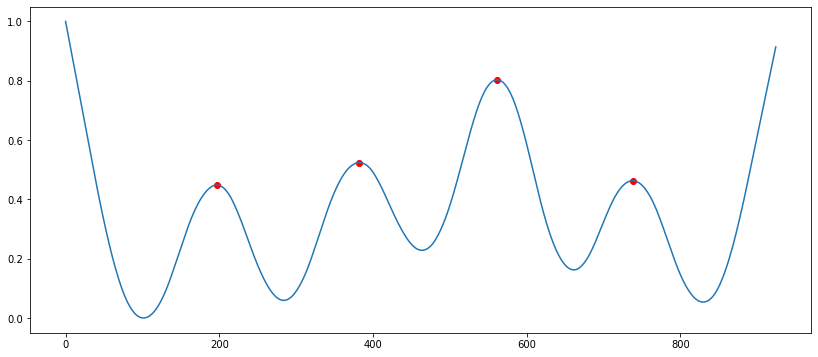

../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize256_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
218
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize128_datasize64_total_epoch10_totaldata5000.csv
[총 에포크수]  : 10
82
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize16_datasize224_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
227
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize32_datasize256_total_epoch10_totaldata2000.csv
[총 에포크수]  : 10
261
../1_Hardware_Data/DataSet/RawData/CPU+GPU/g4dn/ResNetSmall_batchsize128_datasize32_total_epoch10_totaldata50000.csv
[총 에포크수]  : 10
355
[ 1 EPOCH latency 평균 ? ]  :  0:00:04.007100
list is not empty
[ 예측한 1 EPOCH latency 평균 ? ]  :  3.4735
클러스터 레이블 : 
[0 1 2 3 4]
클러스터 갯수 : 4
sum 데이터 분산  :  1.892671033259383
luminol 분산  :  0.0724087585214839
luminol 표준편차  :  0.2690887558436508
luminol 평균값 : 0.41425444486069896
luminol 중앙값 : 0.35616275860586777


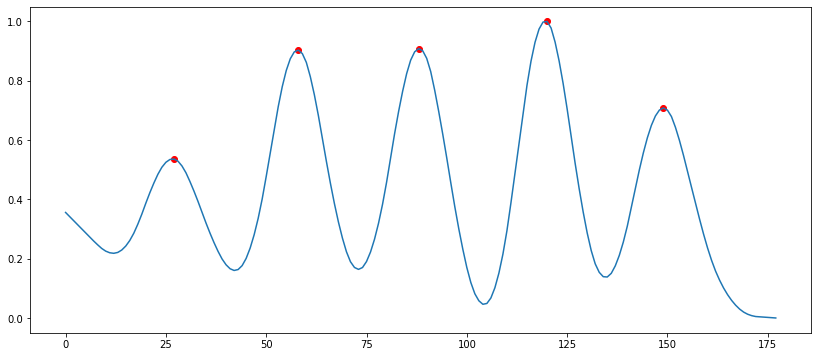

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
ResNetSmall*
mae
0.42163999999999974
rsme
0.4271757635915219
mape
6.83202509249637
r2
0.9956933913361055


In [8]:
for model in model_list: # 모델별로 실행한다.
    
    all_true_df = []  # 원조 1 epoch latency 평균
    all_pred_df_gpucpu =[]  # 예측한 1 epoch latency 
    
    try:  # 해당모델없으면 에러무시하고 넘어가기
        print("-----------------------------------------------------------------")
        print(model)
        filenames = glob.glob(str(Instance)+'/'+str(model) )
        
        for file in filenames: # 해당 모델이름으로 필터링된 파일 모두살펴보기
            print(file) #이 파일위주로 볼것이다.
            
            # 모델별로 epoch 시작과끝 기록한 파일열어서 array 에 저장
            epoch_start_timestamp_array, epoch_end_timestamp_array, epoch_start_end_timestamp_Dataframe = hw_functions.per_model_csv(file)
            print( '[총 에포크수]  : ' + str(  len(epoch_start_timestamp_array)))
            
            # epoch 시작 끝지점이 Data_T 랑 완전히 같지않기 때문에 가장 가까운 지점만 골라내줌 -------------------------------------
            epoch_start_timestamp_nearest, epoch_end_timestamp_nearest, epoch_start_list, epoch_end_list = hw_functions.epoch_start_end_to_list(Data_GPUCPU, epoch_start_timestamp_array ,epoch_end_timestamp_array)

            # Data_T2 : 해당 모델 데이터만 가지고 살펴본다 ------------------------------------------------------------------------
            # 시작한지점이랑 끝난지점 기준으로 데이터 앞뒤 잘라내줌.-------------------------------------------------------

            Data_T2 = Data_GPUCPU[epoch_start_list[0]:epoch_end_list[len(epoch_end_list)-1]]
            Data_T2 = Data_T2.reset_index()
            
            print(len(Data_T2))
            if(len(Data_T2)>300 and len(Data_T2)<1999*10):   # 총길이가 100미만인거는 결과가 너무안좋아서 뺌
                # 잘라주고 나서 epoch start, end 리스트 재배치 ------------------------------------------
                start = epoch_start_list[0] 
                for i in range(len(epoch_start_list)):
                    epoch_start_list[i] = epoch_start_list[i] - start
                for i in range(len(epoch_end_list)):
                    epoch_end_list[i] = epoch_end_list[i] - start
                # epoch 매겨주기---------------------------------------------------------------------
                Data_T2['epoch'] = 0
                epoch_num = 0
                for i in range(len(Data_T2)):
                    if i in epoch_start_list:
                        epoch_num = epoch_num+1
                    Data_T2.iloc[i:i+1]['epoch'] = epoch_num


                Data_T3 = Data_T2
                
                # 진짜 1 epoch latency average 구하기
                #dataframe 이 2/22 2:2:2.000 인경우 뒤의 0을 제외하고 [:-3 으로 계산해서 에러나기때문]
                if(len(str(Data_T3['date_x'][len(Data_T3)-1])[:-3]) != 26):
                    d2 = datetime.strptime(str(Data_T3['date_x'][len(Data_T3)-2])[:-3], "%Y-%m-%d %H:%M:%S.%f")
                else:
                    d2 = datetime.strptime(str(Data_T3['date_x'][len(Data_T3)-1])[:-3], "%Y-%m-%d %H:%M:%S.%f")

                if(len(str(Data_T3['date_x'][0])[:-3]) != 26):
                    d1 = datetime.strptime(str(Data_T3['date_x'][1])[:-3], "%Y-%m-%d %H:%M:%S.%f")
                else:
                    d1 = datetime.strptime(str(Data_T3['date_x'][0])[:-3], "%Y-%m-%d %H:%M:%S.%f")
                total_latency_second = float(str((d2-d1).total_seconds()))
                one_epoch_average_second = float(str((d2-d1).total_seconds()))/10
                print(  '[ 1 EPOCH latency 평균 ? ]  :  ' + str((d2-d1)/10))
                ####################################################################################
                total_latency = float(str((d2-d1).total_seconds()))
                one_epoch_latency = float(str((d2-d1).total_seconds()))/10
                
                
                all_true_df.append(one_epoch_average_second)  # 찐 epoch 길이구함.
                T_all_true_df.append(one_epoch_average_second)

                # -------------------------------------------------------------------------------------
                # ----1999-----------------------------------------------------------------------------

                #Data_T3 = Data_T3[0:1999] # 루미놀의 한계
                Data_T3 = Data_T3[int(len(Data_T3)/2):]
                Data_T3 = Data_T3[0:1999] # 루미놀의 한계
                Data_T3 = Data_T3.reset_index()

                # df 에 저장해줄값들 정의해줌. ###################################################
                cpu_utilization_peak = Data_T3['totalcpuusage_usr'].max()
                cpu_utilization_average = Data_T3['totalcpuusage_usr'].mean()
                gpu_utilization_peak  =  Data_T3['utilization.gpu[%]'].max()
                gpu_utilization_average = Data_T3['utilization.gpu[%]'].mean()
                gpu_utilization_memory_peak =  Data_T3['utilization.memory[%]'].max()
                gpu_utilization_memory_average = Data_T3['utilization.memory[%]'].mean()
            
            
                Data_T3['totalcpuusage_usr'] = hw_functions.min_max_normalize(Data_T3['totalcpuusage_usr'])
                Data_T3['utilization.gpu[%]'] = hw_functions.min_max_normalize(Data_T3['utilization.gpu[%]'])
                Data_T3['sum'] =  Data_T3['totalcpuusage_usr'] + 7*Data_T3['utilization.gpu[%]']
                ###########################################################################
                gpu_cpu_utilization_average = Data_T3['sum'].mean()
                gpu_cpu_utilization_peak = Data_T3['sum'].max()
                sum_variance = Data_T3['sum'].var()
                sum_standared_deviation = math.sqrt(Data_T3['sum'].var()) 
                sum_mean = Data_T3['sum'].mean()
                sum_median = Data_T3['sum'].median()
                
                

                if(len(Data_T3) < 800):
                    holsu = 21
                    if(len(Data_T3) < 200):
                        holsu = 11
                else:
                    holsu = 81
                if(len(Data_T3) > 1500):
                    holsu = 101
                
                
                Data_T3['luminol_first'] = hw_functions.scoreLuminolALLData(Data_T3['sum'])              
                data = np.array(Data_T3['luminol_first'] )
                w = savgol_filter(data,holsu, 1)                    
                wseries = pd.Series(w)
                
                # 루미놀결과값에 normalization 해준다음, 필터 2th + Normalization 해줌
                Data_T3['luminol_first_normalize'] = hw_functions.min_max_normalize(wseries)
                data = np.array(Data_T3['luminol_first_normalize'] )
                w = savgol_filter(data, holsu , 1)
                wseries = pd.Series(w)
                
                Data_T3['luminol_second_normalize'] = hw_functions.min_max_normalize(wseries)
                data = np.array(Data_T3['luminol_second_normalize'] )
                w = savgol_filter(data, holsu , 1)
                wseries = pd.Series(w)
                Data_T3['luminol'] = hw_functions.min_max_normalize(wseries)
                
                # 피크값 뽑아내기 -------------------------------------------------------
                graph_data = Data_T3['luminol']
                data = list(graph_data)

                peaks, _ = find_peaks(data, prominence =0.01) 
                df_high_score_ = list(peaks)
                for i in df_high_score_:
                    if(data[i] < Data_T3['luminol'].mean()):
                        df_high_score_.remove(i)
                if df_high_score_: # 비어있지 않을때
                    print("list is not empty")
                else:  # 피크값이 하나도 없을때 (예외처리)
                    print("list is empty")
                    pass


                #----------------------------------------------------------------------
                anomaly_pd = pd.DataFrame(df_high_score_)
                anomaly_pd['index'] = anomaly_pd.index
                anomaly_pd.columns = ['x', 'y']
                a = anomaly_pd['x']
                b = 0
                for i in range(1,len(a)):
                    b += a[i] - a[i-1]

                eps = (b/(len(a)))*(2/3)
                if(eps == 0 ):
                    eps  = 0.5
                anomaly_pd_list = list(anomaly_pd['x'])
                anomaly_pd['y'] = 1

                X = anomaly_pd.to_numpy()
                dbscan =  DBSCAN(eps , min_samples=1)
                clusters = dbscan.fit_predict(X)


    
                # epoch latency total 2 ( 어노말리로 앞뒤 끊은다음 구함)
                if(len(str(Data_T3['date_x'][df_high_score_[0]])) != 26):
                    d2_1999 = datetime.strptime(str(Data_T3['date_x'][df_high_score_[0]+1])[:-3], "%Y-%m-%d %H:%M:%S.%f")
                else:
                    d2_1999 = datetime.strptime(str(Data_T3['date_x'][df_high_score_[0]])[:-3], "%Y-%m-%d %H:%M:%S.%f")
                if(len(str(Data_T3['date_x'][df_high_score_[-1]])) != 26):
                    d1_1999 = datetime.strptime(str(Data_T3['date_x'][df_high_score_[-1]-1])[:-3], "%Y-%m-%d %H:%M:%S.%f")
                else:
                    d1_1999 = datetime.strptime(str(Data_T3['date_x'][df_high_score_[-1]])[:-3], "%Y-%m-%d %H:%M:%S.%f")

                total_latency_millisecond = (d1_1999-d2_1999).total_seconds()*1000
                total_latency_second2 = (d1_1999-d2_1999).total_seconds()


                cluster_num = int(max(clusters))
                if(cluster_num == 0 ):  # 클러스터가 0이면 나눌때 에러가 나기때문.
                    cluster_num = 1
                    predict_epoch_num = total_latency_second2
                    print(predict_epoch_num)
                else:
                    predict_epoch_num = total_latency_second2/cluster_num

                if(total_latency_second2 == 0):
                    predict_epoch_num = total_latency_second
                
                all_pred_df_gpucpu.append(predict_epoch_num)   
                T_all_pred_df_gpucpu.append(predict_epoch_num)   

                print('[ 예측한 1 EPOCH latency 평균 ? ]  :  ' + str(predict_epoch_num)) 
                print("클러스터 레이블 : \n{}".format(clusters))
                print("클러스터 갯수 : " + str(cluster_num))
                print("sum 데이터 분산  :  " + str(Data_T3['sum'].var()))
                print("luminol 분산  :  " + str(Data_T3['luminol'].var()))
                pjpc = math.sqrt(Data_T3['luminol'].var()) 
                print("luminol 표준편차  :  " + str(pjpc))
                print("luminol 평균값 : " + str(Data_T3['luminol'].mean()))
                print("luminol 중앙값 : " + str(Data_T3['luminol'].median()))
                luminol_variance = Data_T3['sum'].var()
                luminol_standared_deviation = math.sqrt(Data_T3['luminol'].var()) 
                luminol_mean = Data_T3['luminol'].mean()
                luminol_median = Data_T3['luminol'].median()
                
                # 결과 그래프 저장하기 ㅎㅎㅎㅎㅎ  --------------------------------------------------------------------------------------------------------
                plt.plot(range(len(data)), data)
                plt.scatter(df_high_score_, [data[t] for t in df_high_score_], c='red')
                plt.show()


        print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
        print(model)
        all_pred_df = all_pred_df_gpucpu
        
        print("mae")
        print(mean_absolute_error(all_true_df, all_pred_df))

        print("rsme")
        MSE = mean_squared_error(all_true_df, all_pred_df) 
        print(np.sqrt(MSE))

        print('mape')
        print(mean_absolute_percentage_error(all_true_df, all_pred_df)*100)

        print('r2')
        print(r2_score(all_true_df, all_pred_df))
    except:
        pass

In [9]:
print(len(all_true_df))
print(len(all_pred_df_gpucpu))
print(len(T_all_pred_df_gpucpu))
print(len(T_all_true_df))

5
5
120
120


In [10]:
all_pred_df = T_all_pred_df_gpucpu
all_true_df = T_all_true_df

print("mae")
print(mean_absolute_error(all_true_df, all_pred_df))

print("rsme")
MSE = mean_squared_error(all_true_df, all_pred_df) 
print(np.sqrt(MSE))

print('mape')
print(mean_absolute_percentage_error(all_true_df, all_pred_df)*100)

print('r2')
print(r2_score(all_true_df, all_pred_df))


mae
4.891845694444444
rsme
13.582885531044084
mape
11.983827143896503
r2
0.6829125933802448
